In [89]:
# imports
import time
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import lightgbm as lgb

plt.rcParams['figure.figsize'] = [80, 60]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-01-29 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-02-01 00:00:00
train_valid_split_datetime: 2018-01-29 00:00:00


/usr/local/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
manhattan_location_num = len(manhattan_location_ids)
print('manhattan_location_ids:', manhattan_location_ids.shape, manhattan_location_ids)
print('manhattan_location_num:', manhattan_location_num)

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,) [  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]
manhattan_location_num: 69


In [3]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [5]:
first_5min_id = get_5min_id(first_datetime)
first_15min_id = get_15min_id(first_datetime)
first_30min_id = get_30min_id(first_datetime)
print('first_5min_id:', first_5min_id)
print('first_15min_id:', first_15min_id)
print('first_30min_id:', first_30min_id)
last_5min_id = get_5min_id(last_datetime)
last_15min_id = get_15min_id(last_datetime)
last_30min_id = get_30min_id(last_datetime)
print('last_5min_id:', last_5min_id)
print('last_15min_id:', last_15min_id)
print('last_30min_id:', last_30min_id)
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

first_5min_id: 0.0
first_15min_id: 0.0
first_30min_id: 0.0
last_5min_id: 8928.0
last_15min_id: 2976.0
last_30min_id: 1488.0
train_valid_split_5min_id: 8064.0
train_valid_split_15min_id: 2688.0
train_valid_split_30min_id: 1344.0


In [6]:
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [7]:
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 2):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 25.35061287879944
filter PULocationID: (7965703, 17) 6.572152853012085
tpep_pickup_datetime: 8.27407193183899
tpep_dropoff_datetime: 9.79297399520874
filter trip_distance: (7935134, 17) 11.380392074584961
trip_duration: 11.867861986160278
filter trip_duration: (7935017, 18) 13.693463802337646
trip_speed: 13.792375087738037
filter trip_speed: (7931840, 19) 16.67345094680786
filter total_amount: (7928802, 19) 17.69555902481079
filter tpep_pickup_datetime first_datetime: (7928569, 19) 18.662188053131104
filter tpep_pickup_datetime last_datetime: (7928497, 19) 19.62929892539978
filter_abnormal_data: 45.288217067718506
concat: 45.28830409049988
sample_manhattan: (7928497, 19)
total_amount m: 13.526606089401307 s: 9.692531310002575
filter total_amount: (7925658, 19) 0.9008967876434326
trip_distance m: 2.233562362897817 s: 2.4878265305725793
filter trip_distance: (7925654, 19) 1.8727970123291016
trip_duration m: 870.7019522931483 s: 3550.1005807871866
filter trip_duration: (

In [8]:
start = time.time()
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'

tpep_pickup_year: 0.3161780834197998
tpep_pickup_month: 0.5652010440826416
tpep_pickup_day: 0.8444530963897705
tpep_pickup_hour: 1.1258118152618408
tpep_pickup_weekday: 1.4711661338806152
is_weekend: 4.243634223937988
is_morning_peak: 7.089421033859253
is_evening_peak: 9.863148927688599
store_and_fwd_flag: 12.470055103302002
tpep_pickup_5min_id: 12.912075996398926
tpep_pickup_15min_id: 13.32400107383728
tpep_pickup_30min_id: 13.74255895614624


In [9]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,2018,1,1,0,0,0,0,0,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,2018,1,1,0,0,0,0,0,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,2018,1,1,0,0,0,0,0,1.000,0.000,0.000


In [10]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000
mean,1.563,1.610,2.232,1.013,1.000,165.066,162.319,1.305,10.646,0.319,0.499,1.579,0.131,0.300,13.477,722.656,10.756,2018.000,1.000,16.733,13.725,2.853,0.257,0.136,0.188,4701.323,1566.774,783.137
std,0.496,1.261,2.484,0.171,0.000,66.235,69.048,0.474,7.540,0.402,0.023,1.832,0.994,0.003,9.316,511.095,5.269,0.000,0.000,8.708,6.041,1.957,0.437,0.342,0.391,2510.091,836.697,418.349
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-0.500,0.000,0.000,0.000,0.000,0.300,1.000,0.005,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.900,1.000,1.000,114.000,113.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,8.160,368.000,7.385,2018.000,1.000,10.000,9.000,1.000,0.000,0.000,0.000,2683.000,894.000,447.000
50%,2.000,1.000,1.490,1.000,1.000,162.000,162.000,1.000,8.500,0.000,0.500,1.360,0.000,0.300,11.000,597.000,9.704,2018.000,1.000,17.000,14.000,3.000,0.000,0.000,0.000,4789.000,1596.000,798.000
75%,2.000,2.000,2.500,1.000,1.000,234.000,234.000,2.000,12.500,0.500,0.500,2.200,0.000,0.300,15.360,938.000,12.813,2018.000,1.000,24.000,19.000,5.000,1.000,0.000,0.000,6878.000,2292.000,1146.000
max,2.000,9.000,51.900,99.000,1.000,263.000,265.000,4.000,110.000,60.000,0.500,100.510,95.750,0.300,110.400,7966.000,200.000,2018.000,1.000,31.000,23.000,6.000,1.000,1.000,1.000,8927.000,2975.000,1487.000


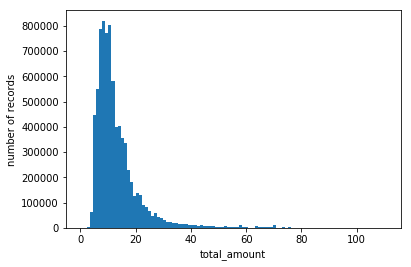

In [11]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

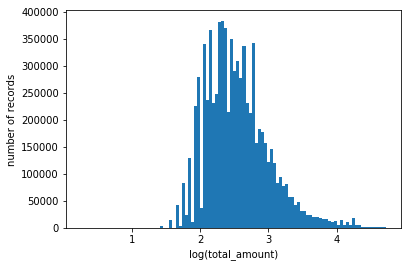

In [12]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

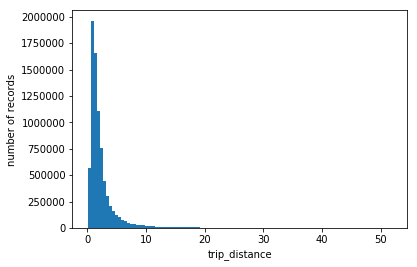

In [13]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

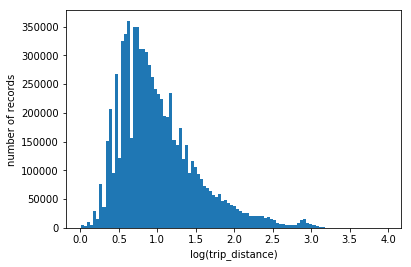

In [14]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

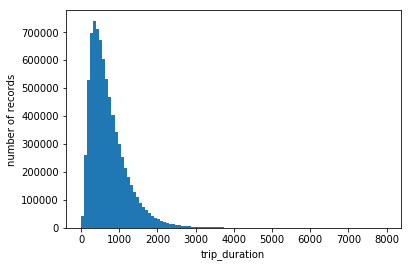

In [15]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

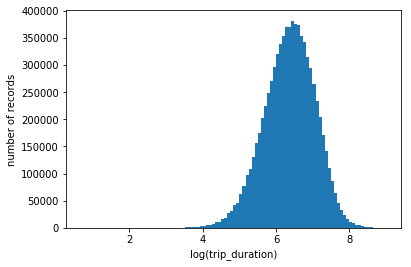

In [16]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

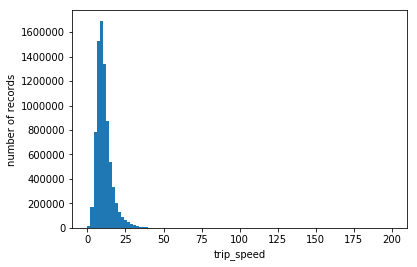

In [17]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

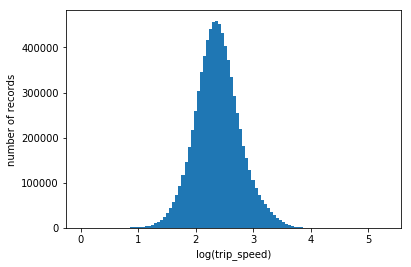

In [18]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

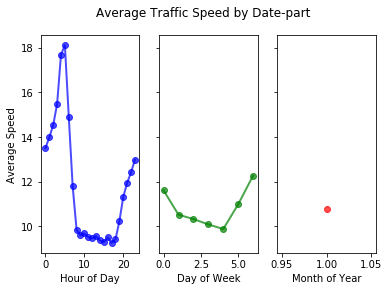

In [19]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

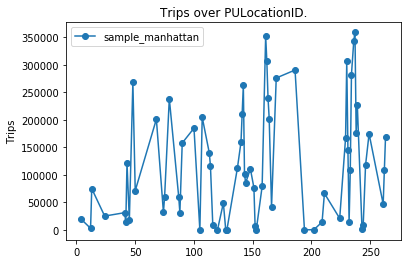

In [20]:
plt.plot(sample_manhattan.groupby(['PULocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over PULocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

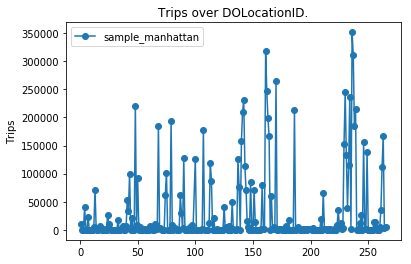

In [21]:
plt.plot(sample_manhattan.groupby(['DOLocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over DOLocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [22]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


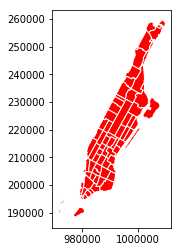

In [23]:
taxi_zones_shape.plot(color='red', edgecolor='white')

In [24]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
PULocationID_group.head()

,VendorID
PULocationID,
4,0.246
12,0.037
13,0.949
24,0.318
41,0.396


In [25]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
print('taxi_zones_shape_requests:', taxi_zones_shape_requests.shape)

taxi_zones_shape_requests: (69, 8)


In [26]:
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",0.246
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",0.037
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",0.949
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",0.318
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",0.396


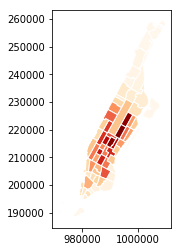

In [27]:
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

In [28]:
#for group_name, group_data in sample_manhattan.groupby(['tpep_pickup_5min_id']):
#    #print('group_name:', group_name)
#    #print(group_data.head())
#    PULocationID_group = group_data.groupby(['PULocationID']).count()[['VendorID']]
#    PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
#    #PULocationID_group.head()
#    taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
#    taxi_zones_shape_requests.fillna(0, inplace=True)
#    #taxi_zones_shape_requests.head()
#    #print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
#    fig = taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')
#    fig.get_figure().savefig('images/'+str(group_name)+'.png')

In [29]:
start = time.time()
all_5min_id = np.array([i for i in range(int(last_5min_id)) for _ in range(manhattan_location_num)])
all_5min_LocationID = np.array([i for _ in range(int(last_5min_id)) for i in manhattan_location_ids])
print('all_5min_id:', all_5min_id.shape, all_5min_id)
print('all_5min_LocationID:', all_5min_LocationID.shape, all_5min_LocationID)

all_5min_index = pd.DataFrame({'tpep_pickup_5min_id': all_5min_id, 'LocationID': all_5min_LocationID})
all_5min_index.set_index(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('all_5min_index:', all_5min_index.shape)

all_5min_static = pd.DataFrame({'tpep_pickup_5min_id': all_5min_id, 'LocationID': all_5min_LocationID})
all_5min_static['tpep_pickup_datetime'] = pd.to_timedelta(all_5min_static['tpep_pickup_5min_id']*5*60, unit='s') + first_datetime
print('tpep_pickup_datetime:', time.time()-start)
#all_5min_static['tpep_pickup_year'] = all_5min_static['tpep_pickup_datetime'].dt.year
#print('tpep_pickup_year:', time.time()-start)
all_5min_static['tpep_pickup_month'] = all_5min_static['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
all_5min_static['tpep_pickup_day'] = all_5min_static['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
all_5min_static['tpep_pickup_hour'] = all_5min_static['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
all_5min_static['tpep_pickup_weekday'] = all_5min_static['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
all_5min_static['is_weekend'] = all_5min_static['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
all_5min_static['is_morning_peak'] = all_5min_static['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
all_5min_static['is_evening_peak'] = all_5min_static['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
all_5min_static.drop(['tpep_pickup_datetime'], axis=1, inplace=True)
all_5min_static.set_index(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('all_5min_static:', all_5min_static.shape)

all_5min_id: (616032,) [   0    0    0 ... 8927 8927 8927]
all_5min_LocationID: (616032,) [  4  12  13 ... 261 262 263]
all_5min_index: (616032, 0)
tpep_pickup_datetime: 0.26003503799438477
tpep_pickup_month: 0.28092002868652344
tpep_pickup_day: 0.3005390167236328
tpep_pickup_hour: 0.3216898441314697
tpep_pickup_weekday: 0.34601902961730957
is_weekend: 0.5871891975402832
is_morning_peak: 0.8107521533966064
is_evening_peak: 1.0288851261138916
all_5min_static: (616032, 7)


In [30]:
all_5min_index.head()

Empty DataFrame
Columns: []
Index: [(0, 4), (0, 12), (0, 13), (0, 24), (0, 41)]

In [31]:
all_5min_index.tail()

Empty DataFrame
Columns: []
Index: [(8927, 246), (8927, 249), (8927, 261), (8927, 262), (8927, 263)]

In [32]:
all_5min_static.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
0                   4                    0                0                0  
                    12                   0                0                0  
                    13                   0                0                0  
                    24                   0                0                0  
                    41                   0                0                0

In [33]:
all_5min_static.tail()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
8927                246                         1               31   
                    249                         1               31   
                    261                         1               31   
                    262                         1               31   
                    263                         1               31   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
8927                246                       23                    2   
                    249                       23                    2   
                    261                       23                    2   
                    262                       23                    2   
                    263                       23                    2   

                                is_weekend  is_morning_peak  is_evening_peak  
tpep_pickup_5min_id LocationID                                                
8927                246                  0                0                0  
                    249                  0                0                0  
                    261                  0                0                0  
                    262                  0                0                0  
                    263                  0                0                0

In [34]:
sample_5min_group = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID'])
sample_5min_count = sample_5min_group.count()
sample_5min_count.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_count:', sample_5min_count.shape)
sample_5min_mean = sample_5min_group.mean()
sample_5min_mean.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_mean:', sample_5min_mean.shape)
sample_5min_sum = sample_5min_group.sum()
sample_5min_sum.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_sum:', sample_5min_sum.shape)
sample_5min_dropoff_group = sample_manhattan.groupby(['tpep_pickup_5min_id', 'DOLocationID'])
sample_5min_dropoff_count = sample_5min_dropoff_group.count()
sample_5min_dropoff_count.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_count:', sample_5min_dropoff_count.shape)
sample_5min_dropoff_mean = sample_5min_dropoff_group.mean()
sample_5min_dropoff_mean.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_mean:', sample_5min_dropoff_mean.shape)
sample_5min_dropoff_sum = sample_5min_dropoff_group.sum()
sample_5min_dropoff_sum.index.rename(['tpep_pickup_5min_id', 'LocationID'], inplace=True)
print('sample_5min_dropoff_sum:', sample_5min_dropoff_sum.shape)

sample_5min_count: (475844, 30)
sample_5min_mean: (475844, 30)
sample_5min_sum: (475844, 30)
sample_5min_dropoff_count: (738210, 30)
sample_5min_dropoff_mean: (738210, 30)
sample_5min_dropoff_sum: (738210, 30)


In [35]:
sample_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  3                3              3   
                    13                 4                4              4   
                    24                 2                2              2   
                    41                 3                3              3   
                    42                 3                3              3   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3             3   
                    13                   4                   4             4   
                    24                   2                   2             2   
                    41                   3                   3             3   
                    42                   3                   3             3   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      3            3      3        3   
                    13                     4            4      4        4   
                    24                     2            2      2        2   
                    41                     3            3      3        3   
                    42                     3            3      3        3   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    3             3   
                    13                   4             4   
                    24                   2             2   
                    41                   3             3   
                    42                   3             3   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               3             3   
                    13                              4             4   
                    24                              2             2   
                    41                              3             3   
                    42                              3             3   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                       3           3                 3   
                    13                      4           4                 4   
                    24                      2           2                 2   
                    41                      3           3                 3   
                    42                      3           3                 3   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           3                3   
                    13                          4                4   
                    24                          2                2   
                    41                          3                3   
                    42                          3                3   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          3                    3   
                    13                         4                    4   
                    24                         2                    2   
                    41                         3                    3

In [36]:
sample_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.333            1.667          1.203   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   
                    42             1.667            1.667          4.920   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000       189.667   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   
                    42               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.333        7.500  0.500    0.500   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   
                    42                 1.333       19.333  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.817         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.617   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   
                    42                          0.300        20.633   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                 501.000       9.918          2018.000   
                    13                524.500      15.570          2018.000   
                    24                709.500      13.941          2018.000   
                    41                376.333      12.232          2018.000   
                    42               1317.000      14.847          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                       1.000            1.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   
                    42                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                      0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000   
                    41                     0.000                0.000

In [37]:
sample_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                5          3.610   
                    13                 8                4          9.740   
                    24                 4                3          5.550   
                    41                 4                4          3.950   
                    42                 5                5         14.760   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    3                   3           569   
                    13                   4                   4           645   
                    24                   2                   2           285   
                    41                   3                   3           355   
                    42                   3                   3           420   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4       22.500  1.500    1.500   
                    13                     6       40.500  2.000    2.000   
                    24                     4       23.000  1.000    1.000   
                    41                     5       21.000  1.500    1.500   
                    42                     4       58.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                2.450         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   
                    42               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.900        28.850   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   
                    42                          0.900        61.900   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                1503.000      29.755              6054   
                    13               2098.000      62.280              8072   
                    24               1419.000      27.883              4036   
                    41               1129.000      36.696              6054   
                    42               3951.000      44.540              6054   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           3                3   
                    13                          4                4   
                    24                          2                2   
                    41                          3                3   
                    42                          3                3   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0

In [38]:
sample_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  4                4              4   
                    7                  2                2              2   
                    13                 3                3              3   
                    17                 1                1              1   
                    18                 1                1              1   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4             4   
                    7                    2                   2             2   
                    13                   3                   3             3   
                    17                   1                   1             1   
                    18                   1                   1             1   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      4            4      4        4   
                    7                      2            2      2        2   
                    13                     3            3      3        3   
                    17                     1            1      1        1   
                    18                     1            1      1        1   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                    4             4   
                    7                    2             2   
                    13                   3             3   
                    17                   1             1   
                    18                   1             1   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                               4             4   
                    7                               2             2   
                    13                              3             3   
                    17                              1             1   
                    18                              1             1   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                       4           4                 4   
                    7                       2           2                 2   
                    13                      3           3                 3   
                    17                      1           1                 1   
                    18                      1           1                 1   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           4                4   
                    7                           2                2   
                    13                          3                3   
                    17                          1                1   
                    18                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          4                    4   
                    7                          2                    2   
                    13                         3                    3   
                    17                         1                    1

In [39]:
sample_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4              1.750            2.250          1.765   
                    7              1.500            1.500          6.375   
                    13             1.667            1.000          0.990   
                    17             2.000            1.000          6.700   
                    18             1.000            2.000          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                1.000               1.000        97.000   
                    7                1.000               1.000       120.500   
                    13               1.000               1.000       119.333   
                    17               1.000               1.000        43.000   
                    18               1.000               1.000       162.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                  1.750        7.875  0.500    0.500   
                    7                  2.000       22.500  0.500    0.500   
                    13                 1.667        5.833  0.500    0.500   
                    17                 2.000       21.500  0.500    0.500   
                    18                 2.000       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                0.362         0.000   
                    7                0.000         0.000   
                    13               0.320         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           0.300         9.538   
                    7                           0.300        23.800   
                    13                          0.300         7.453   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                 427.750      14.872          2018.000   
                    7                1529.500      15.004          2018.000   
                    13                306.667      12.820          2018.000   
                    17               1174.000      20.545          2018.000   
                    18               1618.000      21.805          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                       1.000            1.000   
                    7                       1.000            1.000   
                    13                      1.000            1.000   
                    17                      1.000            1.000   
                    18                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                      0.000                0.000   
                    7                      0.000                0.000   
                    13                     0.000                0.000   
                    17                     0.000                0.000

In [40]:
sample_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0.000               4                  7                9          7.060   
                    7                  3                3         12.750   
                    13                 5                3          2.970   
                    17                 2                1          6.700   
                    18                 1                2          9.800   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0.000               4                    4                   4           388   
                    7                    2                   2           241   
                    13                   3                   3           358   
                    17                   1                   1            43   
                    18                   1                   1           162   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0.000               4                      7       31.500  2.000    2.000   
                    7                      4       45.000  1.000    1.000   
                    13                     5       17.500  1.500    1.500   
                    17                     2       21.500  0.500    0.500   
                    18                     2       30.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0.000               4                1.450         0.000   
                    7                0.000         0.000   
                    13               0.960         0.000   
                    17               0.000         0.000   
                    18               0.000         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0.000               4                           1.200        38.150   
                    7                           0.600        47.600   
                    13                          0.900        22.360   
                    17                          0.300        22.800   
                    18                          0.300        31.800   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0.000               4                1711.000      59.487              8072   
                    7                3059.000      30.007              4036   
                    13                920.000      38.460              6054   
                    17               1174.000      20.545              2018   
                    18               1618.000      21.805              2018   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0.000               4                           4                4   
                    7                           2                2   
                    13                          3                3   
                    17                          1                1   
                    18                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0.000               4                          0                    0   
                    7                          0                    0   
                    13                         0                    0   
                    17                         0                    0

In [41]:
all_5min_count = all_5min_index.join(sample_5min_count, how='left')
all_5min_count.fillna(0, inplace=True)
print('all_5min_count:', all_5min_count.shape)
all_5min_mean = all_5min_index.join(sample_5min_mean, how='left')
all_5min_mean.fillna(0, inplace=True)
print('all_5min_mean:', all_5min_mean.shape)
all_5min_sum = all_5min_index.join(sample_5min_sum, how='left')
all_5min_sum.fillna(0, inplace=True)
print('all_5min_sum:', all_5min_sum.shape)
all_5min_dropoff_count = all_5min_index.join(sample_5min_dropoff_count, how='left')
all_5min_dropoff_count.fillna(0, inplace=True)
print('all_5min_dropoff_count:', all_5min_dropoff_count.shape)
all_5min_dropoff_mean = all_5min_index.join(sample_5min_dropoff_mean, how='left')
all_5min_dropoff_mean.fillna(0, inplace=True)
print('all_5min_dropoff_mean:', all_5min_dropoff_mean.shape)
all_5min_dropoff_sum = all_5min_index.join(sample_5min_dropoff_sum, how='left')
all_5min_dropoff_sum.fillna(0, inplace=True)
print('all_5min_dropoff_sum:', all_5min_dropoff_sum.shape)

all_5min_count: (616032, 30)
all_5min_mean: (616032, 30)
all_5min_sum: (616032, 30)
all_5min_dropoff_count: (616032, 30)
all_5min_dropoff_mean: (616032, 30)
all_5min_dropoff_sum: (616032, 30)


In [42]:
all_5min_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              3.000            3.000          3.000   
                    12             0.000            0.000          0.000   
                    13             4.000            4.000          4.000   
                    24             2.000            2.000          2.000   
                    41             3.000            3.000          3.000   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                3.000               3.000         3.000   
                    12               0.000               0.000         0.000   
                    13               4.000               4.000         4.000   
                    24               2.000               2.000         2.000   
                    41               3.000               3.000         3.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  3.000        3.000  3.000    3.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 4.000        4.000  4.000    4.000   
                    24                 2.000        2.000  2.000    2.000   
                    41                 3.000        3.000  3.000    3.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                3.000         3.000   
                    12               0.000         0.000   
                    13               4.000         4.000   
                    24               2.000         2.000   
                    41               3.000         3.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           3.000         3.000   
                    12                          0.000         0.000   
                    13                          4.000         4.000   
                    24                          2.000         2.000   
                    41                          3.000         3.000   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                   3.000       3.000             3.000   
                    12                  0.000       0.000             0.000   
                    13                  4.000       4.000             4.000   
                    24                  2.000       2.000             2.000   
                    41                  3.000       3.000             3.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       3.000            3.000   
                    12                      0.000            0.000   
                    13                      4.000            4.000   
                    24                      2.000            2.000   
                    41                      3.000            3.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      3.000                3.000   
                    12                     0.000                0.000   
                    13                     4.000                4.000   
                    24                     2.000                2.000

In [43]:
all_5min_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              1.333            1.667          1.203   
                    12             0.000            0.000          0.000   
                    13             2.000            1.000          2.435   
                    24             2.000            1.500          2.775   
                    41             1.333            1.333          1.317   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                1.000               1.000       189.667   
                    12               0.000               0.000         0.000   
                    13               1.000               1.000       161.250   
                    24               1.000               1.000       142.500   
                    41               1.000               1.000       118.333   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  1.333        7.500  0.500    0.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 1.500       10.125  0.500    0.500   
                    24                 2.000       11.500  0.500    0.500   
                    41                 1.667        7.000  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                0.817         0.000   
                    12               0.000         0.000   
                    13               0.580         0.000   
                    24               0.000         0.000   
                    41               0.567         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.300         9.617   
                    12                          0.000         0.000   
                    13                          0.300        12.005   
                    24                          0.300        12.800   
                    41                          0.300         8.867   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                 501.000       9.918          2018.000   
                    12                  0.000       0.000             0.000   
                    13                524.500      15.570          2018.000   
                    24                709.500      13.941          2018.000   
                    41                376.333      12.232          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       1.000            1.000   
                    12                      0.000            0.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [44]:
all_5min_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              4.000            5.000          3.610   
                    12             0.000            0.000          0.000   
                    13             8.000            4.000          9.740   
                    24             4.000            3.000          5.550   
                    41             4.000            4.000          3.950   

                                RatecodeID  store_and_fwd_flag  DOLocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                3.000               3.000       569.000   
                    12               0.000               0.000         0.000   
                    13               4.000               4.000       645.000   
                    24               2.000               2.000       285.000   
                    41               3.000               3.000       355.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  4.000       22.500  1.500    1.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 6.000       40.500  2.000    2.000   
                    24                 4.000       23.000  1.000    1.000   
                    41                 5.000       21.000  1.500    1.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                2.450         0.000   
                    12               0.000         0.000   
                    13               2.320         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.900        28.850   
                    12                          0.000         0.000   
                    13                          1.200        48.020   
                    24                          0.600        25.600   
                    41                          0.900        26.600   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                1503.000      29.755          6054.000   
                    12                  0.000       0.000             0.000   
                    13               2098.000      62.280          8072.000   
                    24               1419.000      27.883          4036.000   
                    41               1129.000      36.696          6054.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       3.000            3.000   
                    12                      0.000            0.000   
                    13                      4.000            4.000   
                    24                      2.000            2.000   
                    41                      3.000            3.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [45]:
all_5min_dropoff_count.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              4.000            4.000          4.000   
                    12             0.000            0.000          0.000   
                    13             3.000            3.000          3.000   
                    24             2.000            2.000          2.000   
                    41             2.000            2.000          2.000   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                4.000               4.000         4.000   
                    12               0.000               0.000         0.000   
                    13               3.000               3.000         3.000   
                    24               2.000               2.000         2.000   
                    41               2.000               2.000         2.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  4.000        4.000  4.000    4.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 3.000        3.000  3.000    3.000   
                    24                 2.000        2.000  2.000    2.000   
                    41                 2.000        2.000  2.000    2.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                4.000         4.000   
                    12               0.000         0.000   
                    13               3.000         3.000   
                    24               2.000         2.000   
                    41               2.000         2.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           4.000         4.000   
                    12                          0.000         0.000   
                    13                          3.000         3.000   
                    24                          2.000         2.000   
                    41                          2.000         2.000   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                   4.000       4.000             4.000   
                    12                  0.000       0.000             0.000   
                    13                  3.000       3.000             3.000   
                    24                  2.000       2.000             2.000   
                    41                  2.000       2.000             2.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       4.000            4.000   
                    12                      0.000            0.000   
                    13                      3.000            3.000   
                    24                      2.000            2.000   
                    41                      2.000            2.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      4.000                4.000   
                    12                     0.000                0.000   
                    13                     3.000                3.000   
                    24                     2.000                2.000

In [46]:
all_5min_dropoff_mean.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              1.750            2.250          1.765   
                    12             0.000            0.000          0.000   
                    13             1.667            1.000          0.990   
                    24             2.000            1.000          3.050   
                    41             1.500            1.000          1.320   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                1.000               1.000        97.000   
                    12               0.000               0.000         0.000   
                    13               1.000               1.000       119.333   
                    24               1.000               1.000       234.000   
                    41               1.000               1.000       140.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  1.750        7.875  0.500    0.500   
                    12                 0.000        0.000  0.000    0.000   
                    13                 1.667        5.833  0.500    0.500   
                    24                 2.000       11.750  0.500    0.500   
                    41                 1.500        7.500  0.500    0.500   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                0.362         0.000   
                    12               0.000         0.000   
                    13               0.320         0.000   
                    24               0.000         0.000   
                    41               0.850         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           0.300         9.538   
                    12                          0.000         0.000   
                    13                          0.300         7.453   
                    24                          0.300        13.050   
                    41                          0.300         9.650   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                 427.750      14.872          2018.000   
                    12                  0.000       0.000             0.000   
                    13                306.667      12.820          2018.000   
                    24                733.000      14.451          2018.000   
                    41                424.500      10.980          2018.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       1.000            1.000   
                    12                      0.000            0.000   
                    13                      1.000            1.000   
                    24                      1.000            1.000   
                    41                      1.000            1.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [47]:
all_5min_dropoff_sum.head()

VendorID  passenger_count  trip_distance  \
tpep_pickup_5min_id LocationID                                             
0                   4              7.000            9.000          7.060   
                    12             0.000            0.000          0.000   
                    13             5.000            3.000          2.970   
                    24             4.000            2.000          6.100   
                    41             3.000            2.000          2.640   

                                RatecodeID  store_and_fwd_flag  PULocationID  \
tpep_pickup_5min_id LocationID                                                 
0                   4                4.000               4.000       388.000   
                    12               0.000               0.000         0.000   
                    13               3.000               3.000       358.000   
                    24               2.000               2.000       468.000   
                    41               2.000               2.000       280.000   

                                payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_5min_id LocationID                                              
0                   4                  7.000       31.500  2.000    2.000   
                    12                 0.000        0.000  0.000    0.000   
                    13                 5.000       17.500  1.500    1.500   
                    24                 4.000       23.500  1.000    1.000   
                    41                 3.000       15.000  1.000    1.000   

                                tip_amount  tolls_amount  \
tpep_pickup_5min_id LocationID                             
0                   4                1.450         0.000   
                    12               0.000         0.000   
                    13               0.960         0.000   
                    24               0.000         0.000   
                    41               1.700         0.000   

                                improvement_surcharge  total_amount  \
tpep_pickup_5min_id LocationID                                        
0                   4                           1.200        38.150   
                    12                          0.000         0.000   
                    13                          0.900        22.360   
                    24                          0.600        26.100   
                    41                          0.600        19.300   

                                trip_duration  trip_speed  tpep_pickup_year  \
tpep_pickup_5min_id LocationID                                                
0                   4                1711.000      59.487          8072.000   
                    12                  0.000       0.000             0.000   
                    13                920.000      38.460          6054.000   
                    24               1466.000      28.903          4036.000   
                    41                849.000      21.960          4036.000   

                                tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                       4.000            4.000   
                    12                      0.000            0.000   
                    13                      3.000            3.000   
                    24                      2.000            2.000   
                    41                      2.000            2.000   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                      0.000                0.000   
                    12                     0.000                0.000   
                    13                     0.000                0.000   
                    24                     0.000                0.000

In [48]:
all_5min = all_5min_count.copy()
all_5min = all_5min.join(all_5min_mean, lsuffix='_count', rsuffix='_mean')
all_5min = all_5min.join(all_5min_sum, rsuffix='_sum')
all_5min = all_5min.join(all_5min_dropoff_count, rsuffix='_dropoff_count')
all_5min = all_5min.join(all_5min_dropoff_mean, rsuffix='_dropoff_mean')
all_5min = all_5min.join(all_5min_dropoff_sum, rsuffix='_dropoff_sum')
print('all_5min:', all_5min.shape)

all_5min: (616032, 180)


In [49]:
all_5min.head()

VendorID_count  passenger_count_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                    3.000                  3.000   
                    12                   0.000                  0.000   
                    13                   4.000                  4.000   
                    24                   2.000                  2.000   
                    41                   3.000                  3.000   

                                trip_distance_count  RatecodeID_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                         3.000             3.000   
                    12                        0.000             0.000   
                    13                        4.000             4.000   
                    24                        2.000             2.000   
                    41                        3.000             3.000   

                                store_and_fwd_flag_count  DOLocationID_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                              3.000               3.000   
                    12                             0.000               0.000   
                    13                             4.000               4.000   
                    24                             2.000               2.000   
                    41                             3.000               3.000   

                                payment_type_count  fare_amount_count  \
tpep_pickup_5min_id LocationID                                          
0                   4                        3.000              3.000   
                    12                       0.000              0.000   
                    13                       4.000              4.000   
                    24                       2.000              2.000   
                    41                       3.000              3.000   

                                extra_count  mta_tax_count  tip_amount_count  \
tpep_pickup_5min_id LocationID                                                 
0                   4                 3.000          3.000             3.000   
                    12                0.000          0.000             0.000   
                    13                4.000          4.000             4.000   
                    24                2.000          2.000             2.000   
                    41                3.000          3.000             3.000   

                                tolls_amount_count  \
tpep_pickup_5min_id LocationID                       
0                   4                        3.000   
                    12                       0.000   
                    13                       4.000   
                    24                       2.000   
                    41                       3.000   

                                improvement_surcharge_count  \
tpep_pickup_5min_id LocationID                                
0                   4                                 3.000   
                    12                                0.000   
                    13                                4.000   
                    24                                2.000   
                    41                                3.000   

                                total_amount_count  trip_duration_count  \
tpep_pickup_5min_id LocationID                                            
0                   4                        3.000                3.000   
                    12                       0.000                0.000   
                    13                       4.000                4.000   
                    24                       2.000                2.000   
                    41                       3.000                3.000   

                           

In [50]:
all_5min_features = all_5min_static.copy()
all_5min_features['value'] = all_5min['VendorID_count']
all_5min_features['5min_ago'] = all_5min['VendorID_count'].shift(manhattan_location_num)
all_5min_features['5min_10min_ago'] = all_5min['VendorID_count'].shift(2*manhattan_location_num)
all_5min_features['10min_ago'] = all_5min_features['5min_ago'] + all_5min_features['5min_10min_ago']
all_5min_features['10min_15min_ago'] = all_5min['VendorID_count'].shift(3*manhattan_location_num)
all_5min_features['15min_ago'] = all_5min_features['10min_ago'] + all_5min_features['10min_15min_ago']
all_5min_features['15min_20min_ago'] = all_5min['VendorID_count'].shift(4*manhattan_location_num)
all_5min_features['20min_ago'] = all_5min_features['15min_ago'] + all_5min_features['15min_20min_ago']
all_5min_features['20min_25min_ago'] = all_5min['VendorID_count'].shift(5*manhattan_location_num)
all_5min_features['25min_ago'] = all_5min_features['20min_ago'] + all_5min_features['20min_25min_ago']
all_5min_features['25min_30min_ago'] = all_5min['VendorID_count'].shift(6*manhattan_location_num)
all_5min_features['30min_ago'] = all_5min_features['25min_ago'] + all_5min_features['25min_30min_ago']
all_5min_features['5min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(manhattan_location_num)
all_5min_features['5min_10min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(2*manhattan_location_num)
all_5min_features['10min_ago_drop'] = all_5min_features['5min_ago_drop'] + all_5min_features['5min_10min_ago_drop']
all_5min_features['10min_15min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(3*manhattan_location_num)
all_5min_features['15min_ago_drop'] = all_5min_features['10min_ago_drop'] + all_5min_features['10min_15min_ago_drop']
all_5min_features['15min_20min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(4*manhattan_location_num)
all_5min_features['20min_ago_drop'] = all_5min_features['15min_ago_drop'] + all_5min_features['15min_20min_ago_drop']
all_5min_features['20min_25min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(5*manhattan_location_num)
all_5min_features['25min_ago_drop'] = all_5min_features['20min_ago_drop'] + all_5min_features['20min_25min_ago_drop']
all_5min_features['25min_30min_ago_drop'] = all_5min['VendorID_dropoff_count'].shift(6*manhattan_location_num)
all_5min_features['30min_ago_drop'] = all_5min_features['25min_ago_drop'] + all_5min_features['25min_30min_ago_drop']
all_5min_features['1day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24)
all_5min_features['7day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*7)
all_5min_features['14day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*14)
all_5min_features['21day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*21)
all_5min_features['28day_ago_now'] = all_5min['VendorID_count'].shift(manhattan_location_num*12*24*28)
all_5min_features.fillna(0, inplace=True)
#all_5min_features.drop(['tpep_pickup_hour'], axis=1, inplace=True)  # TODO why?  # 'tpep_pickup_month', 'tpep_pickup_day', 'tpep_pickup_hour', 'tpep_pickup_weekday', 'is_weekend', 'is_morning_peak', 'is_evening_peak'
print('all_5min_features:', all_5min_features.shape)

all_5min_features: (616032, 35)


In [51]:
all_5min_features.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

In [52]:
train_X_5min = all_5min_features[:int(train_valid_split_5min_id)*manhattan_location_num]
print('train_X_5min:', train_X_5min.shape)
valid_X_5min = all_5min_features[int(train_valid_split_5min_id)*manhattan_location_num:int(last_5min_id)*manhattan_location_num]
print('valid_X_5min:', valid_X_5min.shape)
train_Y_5min = train_X_5min['value'].values
print('train_Y_5min:', len(train_Y_5min))
valid_Y_5min = valid_X_5min['value'].values
print('valid_Y_5min:', len(valid_Y_5min))

train_X_5min: (556416, 35)
valid_X_5min: (59616, 35)
train_Y_5min: 556416
valid_Y_5min: 59616


In [53]:
train_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
0                   4                           1                1   
                    12                          1                1   
                    13                          1                1   
                    24                          1                1   
                    41                          1                1   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
0                   4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
0                   4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
0                   4           3.000     0.000           0.000      0.000   
                    12          0.000     0.000           0.000      0.000   
                    13          4.000     0.000           0.000      0.000   
                    24          2.000     0.000           0.000      0.000   
                    41          3.000     0.000           0.000      0.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
0                   4                     0.000      0.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    0.000      0.000            0.000   
                    24                    0.000      0.000            0.000   
                    41                    0.000      0.000            0.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
0                   4               0.000            0.000      0.000   
                    12              0.000            0.000      0.000   
                    13              0.000            0.000      0.000   
                    24              0.000            0.000      0.000   
                    41              0.000            0.000      0.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
0                   4                     0.000      0.000          0.000   
                    12                    0.000      0.000          0.000   
                    13                    0.000      0.000          0.000   
                    24                    0.000      0.000          0.000   
                    41                    0.000      0.000          0.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
0                   4                         0.000           0.000   
                    12                        0.000           0.000   
                    13         

In [54]:
train_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000,556416.000
mean,1.000,14.500,11.500,3.000,0.286,0.125,0.125,12.765,12.764,12.764,25.528,12.763,38.288,12.762,51.046,12.761,63.801,12.761,76.553,11.923,11.922,23.844,11.921,35.764,11.921,47.681,11.920,59.595,11.919,71.506,12.348,9.325,5.989,2.632,0.000
std,0.000,8.078,6.922,2.000,0.452,0.331,0.331,16.689,16.689,16.690,32.972,16.690,49.218,16.690,65.433,16.690,81.618,16.691,97.779,14.745,14.745,29.072,14.746,43.382,14.746,57.674,14.746,71.946,14.747,86.200,16.615,15.109,12.644,8.357,0.000
min,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,7.750,5.750,1.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,4.000,1.000,5.000,1.000,6.000,1.000,1.000,3.000,1.000,4.000,1.000,6.000,1.000,7.000,1.000,9.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,14.500,11.500,3.000,0.000,0.000,0.000,6.000,6.000,6.000,11.000,6.000,17.000,6.000,23.000,6.000,29.000,6.000,35.000,6.000,6.000,13.000,6.000,19.000,6.000,25.000,6.000,32.000,6.000,38.000,5.000,2.000,0.000,0.000,0.000
75%,1.000,21.250,17.250,5.000,1.000,0.000,0.000,19.000,19.000,19.000,39.000,19.000,58.000,19.000,78.000,19.000,98.000,19.000,117.000,18.000,18.000,36.000,18.000,54.000,18.000,72.000,18.000,90.000,18.000,107.000,19.000,13.000,5.000,0.000,0.000
max,1.000,28.000,23.000,6.000,1.000,1.000,1.000,173.000,173.000,173.000,334.000,173.000,478.000,173.000,631.000,173.000,773.000,173.000,918.000,161.000,161.000,313.000,161.000,459.000,161.000,605.000,161.000,745.000,161.000,882.000,157.000,157.000,150.000,128.000,0.000


In [55]:
valid_X_5min.head()

tpep_pickup_month  tpep_pickup_day  \
tpep_pickup_5min_id LocationID                                       
8064                4                           1               29   
                    12                          1               29   
                    13                          1               29   
                    24                          1               29   
                    41                          1               29   

                                tpep_pickup_hour  tpep_pickup_weekday  \
tpep_pickup_5min_id LocationID                                          
8064                4                          0                    0   
                    12                         0                    0   
                    13                         0                    0   
                    24                         0                    0   
                    41                         0                    0   

                                is_weekend  is_morning_peak  is_evening_peak  \
tpep_pickup_5min_id LocationID                                                 
8064                4                    0                0                0   
                    12                   0                0                0   
                    13                   0                0                0   
                    24                   0                0                0   
                    41                   0                0                0   

                                value  5min_ago  5min_10min_ago  10min_ago  \
tpep_pickup_5min_id LocationID                                               
8064                4           2.000     1.000           3.000      4.000   
                    12          1.000     0.000           0.000      0.000   
                    13          1.000     1.000           1.000      2.000   
                    24          1.000     0.000           0.000      0.000   
                    41          1.000     1.000           2.000      3.000   

                                10min_15min_ago  15min_ago  15min_20min_ago  \
tpep_pickup_5min_id LocationID                                                
8064                4                     0.000      4.000            0.000   
                    12                    0.000      0.000            0.000   
                    13                    2.000      4.000            0.000   
                    24                    2.000      2.000            0.000   
                    41                    3.000      6.000            3.000   

                                20min_ago  20min_25min_ago  25min_ago  \
tpep_pickup_5min_id LocationID                                          
8064                4               4.000            1.000      5.000   
                    12              0.000            0.000      0.000   
                    13              4.000            1.000      5.000   
                    24              2.000            1.000      3.000   
                    41              9.000            0.000      9.000   

                                25min_30min_ago  30min_ago  5min_ago_drop  \
tpep_pickup_5min_id LocationID                                              
8064                4                     2.000      7.000          4.000   
                    12                    0.000      0.000          0.000   
                    13                    3.000      8.000          4.000   
                    24                    2.000      5.000          2.000   
                    41                    0.000      9.000          2.000   

                                5min_10min_ago_drop  10min_ago_drop  \
tpep_pickup_5min_id LocationID                                        
8064                4                         2.000           6.000   
                    12                        0.000           0.000   
                    13         

In [56]:
valid_X_5min.describe()

,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,value,5min_ago,5min_10min_ago,10min_ago,10min_15min_ago,15min_ago,15min_20min_ago,20min_ago,20min_25min_ago,25min_ago,25min_30min_ago,30min_ago,5min_ago_drop,5min_10min_ago_drop,10min_ago_drop,10min_15min_ago_drop,15min_ago_drop,15min_20min_ago_drop,20min_ago_drop,20min_25min_ago_drop,25min_ago_drop,25min_30min_ago_drop,30min_ago_drop,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000,59616.000
mean,1.000,30.000,11.500,1.000,0.000,0.125,0.125,13.563,13.560,13.555,27.115,13.551,40.666,13.545,54.211,13.540,67.750,13.533,81.284,12.723,12.720,25.443,12.716,38.159,12.711,50.870,12.707,63.577,12.701,76.278,12.569,13.204,12.816,12.543,10.939
std,0.000,0.817,6.922,0.817,0.000,0.331,0.331,18.140,18.139,18.138,35.877,18.137,53.576,18.135,71.245,18.134,88.887,18.131,106.499,16.202,16.202,32.001,16.202,47.785,16.203,63.553,16.203,79.299,16.203,95.024,16.683,17.767,17.051,16.562,14.387
min,1.000,29.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,29.000,5.750,0.000,0.000,0.000,0.000,1.000,1.000,1.000,2.000,1.000,3.000,1.000,4.000,1.000,5.000,1.000,6.000,1.000,1.000,3.000,1.000,4.000,1.000,6.000,1.000,7.000,1.000,9.000,1.000,1.000,1.000,1.000,1.000
50%,1.000,30.000,11.500,1.000,0.000,0.000,0.000,6.000,6.000,6.000,12.000,6.000,18.000,6.000,24.000,6.000,30.000,6.000,36.000,6.000,6.000,12.000,6.000,19.000,6.000,25.000,6.000,31.000,6.000,37.000,6.000,5.000,5.000,5.000,5.000
75%,1.000,31.000,17.250,2.000,0.000,0.000,0.000,21.000,21.000,21.000,42.000,21.000,63.000,21.000,84.000,21.000,105.000,21.000,126.000,19.000,19.000,38.000,19.000,58.000,19.000,77.000,19.000,97.000,19.000,116.000,19.000,20.000,19.250,19.000,16.000
max,1.000,31.000,23.000,2.000,0.000,1.000,1.000,135.000,135.000,135.000,252.000,135.000,366.000,135.000,476.000,135.000,590.000,135.000,699.000,156.000,156.000,294.000,156.000,442.000,156.000,574.000,156.000,694.000,156.000,816.000,173.000,148.000,137.000,129.000,128.000


In [92]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('value', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('value', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    param['max_depth'] = 6  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'
    param['objective'] = 'reg:linear'
    # param['objective'] = 'reg:gamma'
    
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 100

    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))
    
    pred = bst.predict(xg_test)
    return pred

In [93]:
def lr_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = LinearRegression()
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [94]:
def rfc_train_validate(train_X, train_Y, test_X, test_Y):
    rfc = RandomForestRegressor(n_estimators=10, criterion='mae', verbose=6)
    rfc.fit(train_X.drop('value', axis=1), train_Y.astype(np.float))
    pred = rfc.predict(test_X.drop('value', axis=1))
    return pred

In [95]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[train_X_5min.shape[1]-1]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def tf_train_validate(train_X, train_Y, test_X, test_Y):
    EPOCHS = 10
    model = build_model()
    model.summary()
    history = model.fit(train_X.drop('value', axis=1), train_Y, epochs=EPOCHS, validation_split = 0.2, verbose=2)
    loss, mae, mse = model.evaluate(test_X.drop('value', axis=1), test_Y, verbose=1)
    pred = model.predict(test_X.drop('value', axis=1)).flatten()
    return pred

In [100]:
def lgb_train_validate(train_X, train_Y, test_X, test_Y):
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(train_X.drop('value', axis=1), train_Y)
    lgb_eval = lgb.Dataset(test_X.drop('value', axis=1), test_Y, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)
    
    print('Starting predicting...')
    # predict
    pred = gbm.predict(test_X.drop('value', axis=1), num_iteration=gbm.best_iteration)
    # eval
    print('The mae of prediction is:', mae(test_Y, pred))
    return pred

In [103]:
pred_5min_xgb = xgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_xgb_mae = mae(valid_Y_5min, pred_5min_xgb)
print('valid_xgb_mae:', valid_xgb_mae)

[0]	train-mae:11.2644	test-mae:11.9985
[1]	train-mae:10.1666	test-mae:10.8358
[2]	train-mae:9.18227	test-mae:9.7862
[3]	train-mae:8.30293	test-mae:8.8446
[4]	train-mae:7.51881	test-mae:8.00831
[5]	train-mae:6.82264	test-mae:7.2604
[6]	train-mae:6.206	test-mae:6.59727
[7]	train-mae:5.66363	test-mae:6.01457
[8]	train-mae:5.18807	test-mae:5.49835
[9]	train-mae:4.77386	test-mae:5.04692
[10]	train-mae:4.41597	test-mae:4.6617
[11]	train-mae:4.10906	test-mae:4.33119
[12]	train-mae:3.84706	test-mae:4.04671
[13]	train-mae:3.6256	test-mae:3.80157
[14]	train-mae:3.43973	test-mae:3.59576
[15]	train-mae:3.28389	test-mae:3.42469
[16]	train-mae:3.1537	test-mae:3.28223
[17]	train-mae:3.04613	test-mae:3.16281
[18]	train-mae:2.95732	test-mae:3.06171
[19]	train-mae:2.88462	test-mae:2.97954
[20]	train-mae:2.8252	test-mae:2.91416
[21]	train-mae:2.77606	test-mae:2.8594
[22]	train-mae:2.73626	test-mae:2.81461
[23]	train-mae:2.70388	test-mae:2.77864
[24]	train-mae:2.677	test-mae:2.74951
[25]	train-mae:2.65502

In [61]:
pred_5min_lr = lr_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_lr_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_lr_mae:', valid_lr_mae)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


valid_lr_mae: 2.7561586814001204


In [62]:
#pred_5min_rfc = rfc_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)  # TODO too slow
#valid_rfc_mae = mae(valid_Y_5min, pred_5min_rfc)
#print('valid_rfc_mae:', valid_rfc_mae)

In [77]:
pred_5min_tf = tf_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_tf_mae = mae(valid_Y_5min, pred_5min_lr)
print('valid_tf_mae:', valid_tf_mae)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                2240      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
Train on 445132 samples, validate on 111284 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
valid_tf_mae: 2.7561586814001204


In [101]:
pred_5min_lgb = lgb_train_validate(train_X_5min, train_Y_5min, valid_X_5min, valid_Y_5min)
valid_lgb_mae = mae(valid_Y_5min, pred_5min_lgb)
print('valid_lgb_mae:', valid_lgb_mae)

Starting training...
[1]	valid_0's l2: 299.812	valid_0's l1: 12.6828
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 272.906	valid_0's l1: 12.0821
[3]	valid_0's l2: 248.665	valid_0's l1: 11.5146
[4]	valid_0's l2: 226.696	valid_0's l1: 10.9756
[5]	valid_0's l2: 206.857	valid_0's l1: 10.4668
[6]	valid_0's l2: 189.031	valid_0's l1: 9.98651
[7]	valid_0's l2: 172.807	valid_0's l1: 9.53067
[8]	valid_0's l2: 158.12	valid_0's l1: 9.09988
[9]	valid_0's l2: 145.019	valid_0's l1: 8.69506
[10]	valid_0's l2: 133.145	valid_0's l1: 8.31324
[11]	valid_0's l2: 122.393	valid_0's l1: 7.95131
[12]	valid_0's l2: 112.631	valid_0's l1: 7.61029
[13]	valid_0's l2: 103.757	valid_0's l1: 7.28801
[14]	valid_0's l2: 95.7394	valid_0's l1: 6.98422
[15]	valid_0's l2: 88.4759	valid_0's l1: 6.69859
[16]	valid_0's l2: 81.8996	valid_0's l1: 6.43118
[17]	valid_0's l2: 75.9993	valid_0's l1: 6.17962
[18]	valid_0's l2: 70.6748	valid_0's l1: 5.94411
[19]	valid_0's l2: 65.8692	valid_0's l1: 5.723

In [104]:
valid_pred_5min = pd.DataFrame(valid_X_5min, columns=['value'])
valid_pred_5min.reset_index(inplace=True)
valid_pred_5min['pred_xgb'] = pred_5min_xgb
valid_pred_5min['pred_lr'] = pred_5min_lr
valid_pred_5min['pred_tf'] = pred_5min_tf
valid_pred_5min['pred_lgb'] = pred_5min_tf
print('valid_pred_5min:', valid_pred_5min.shape)

valid_pred_5min: (59616, 7)


In [105]:
valid_pred_5min.head()

,tpep_pickup_5min_id,LocationID,value,pred_xgb,pred_lr,pred_tf,pred_lgb
0,8064,4,2.000,1.330,1.537,0.988,0.988
1,8064,12,1.000,0.043,-0.346,-0.001,-0.001
2,8064,13,1.000,1.328,1.118,1.003,1.003
3,8064,24,1.000,0.852,0.381,0.515,0.515
4,8064,41,1.000,1.694,1.269,1.037,1.037


group_name: 8064


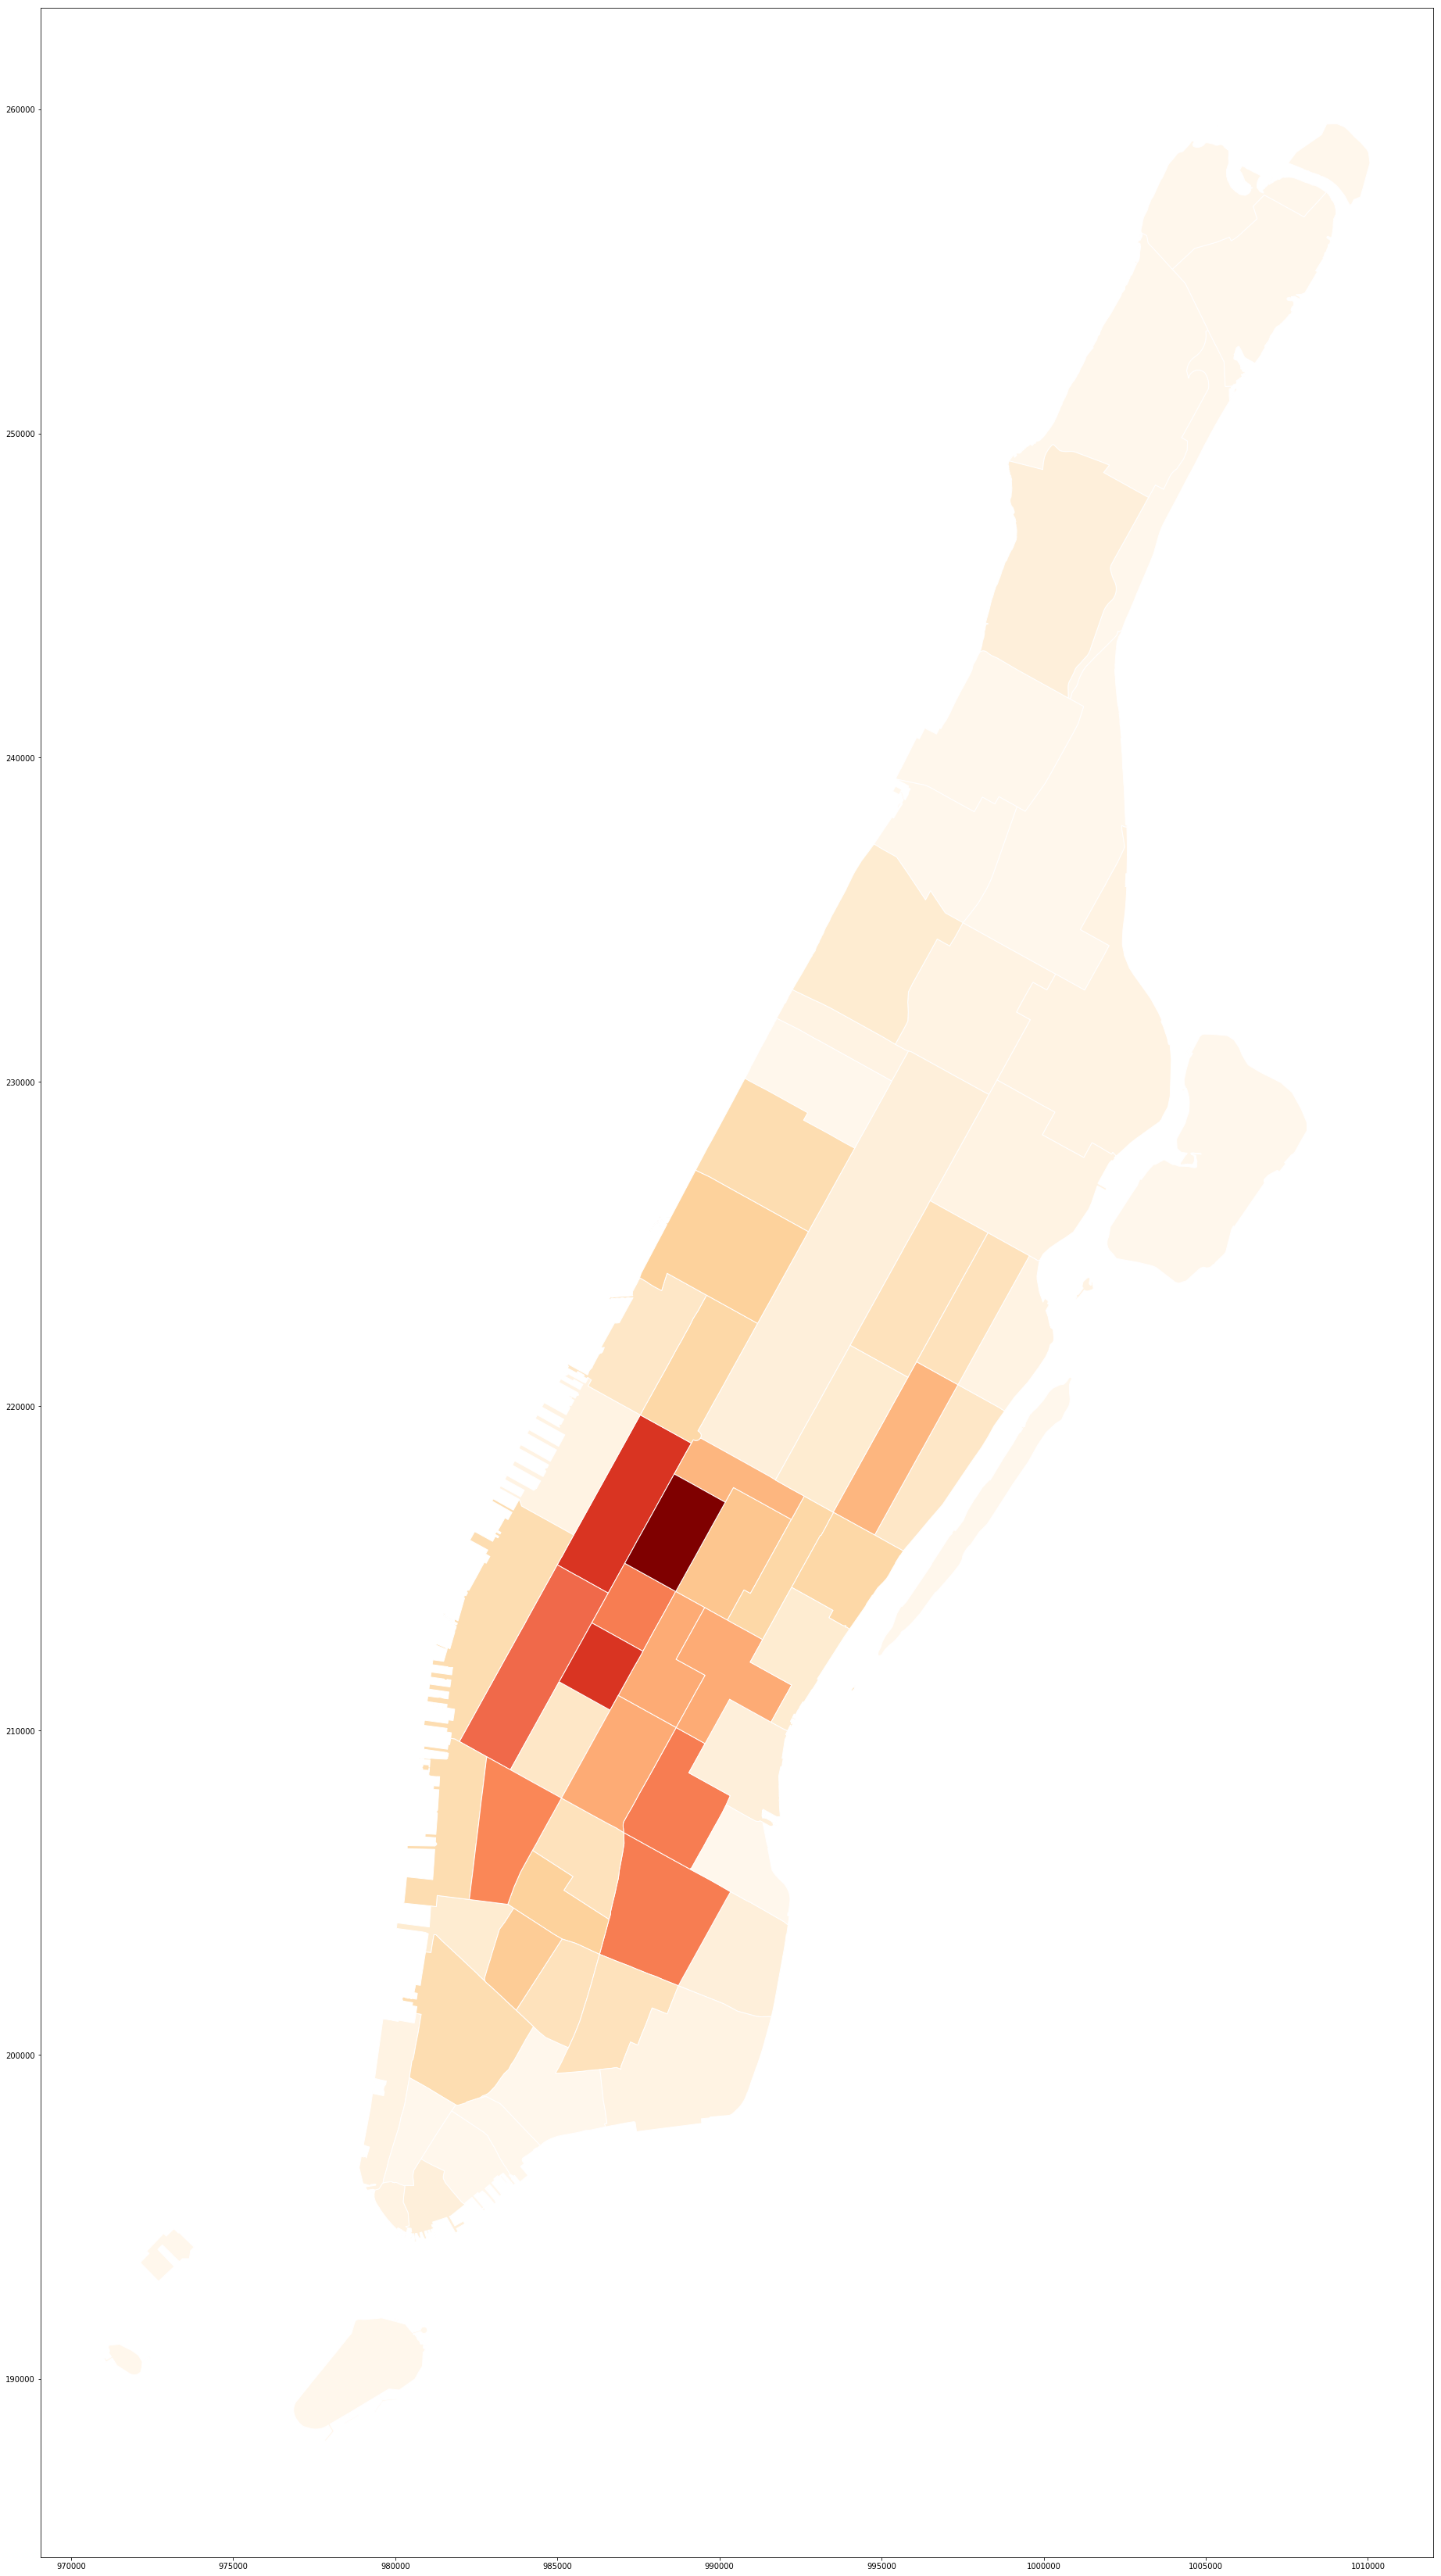

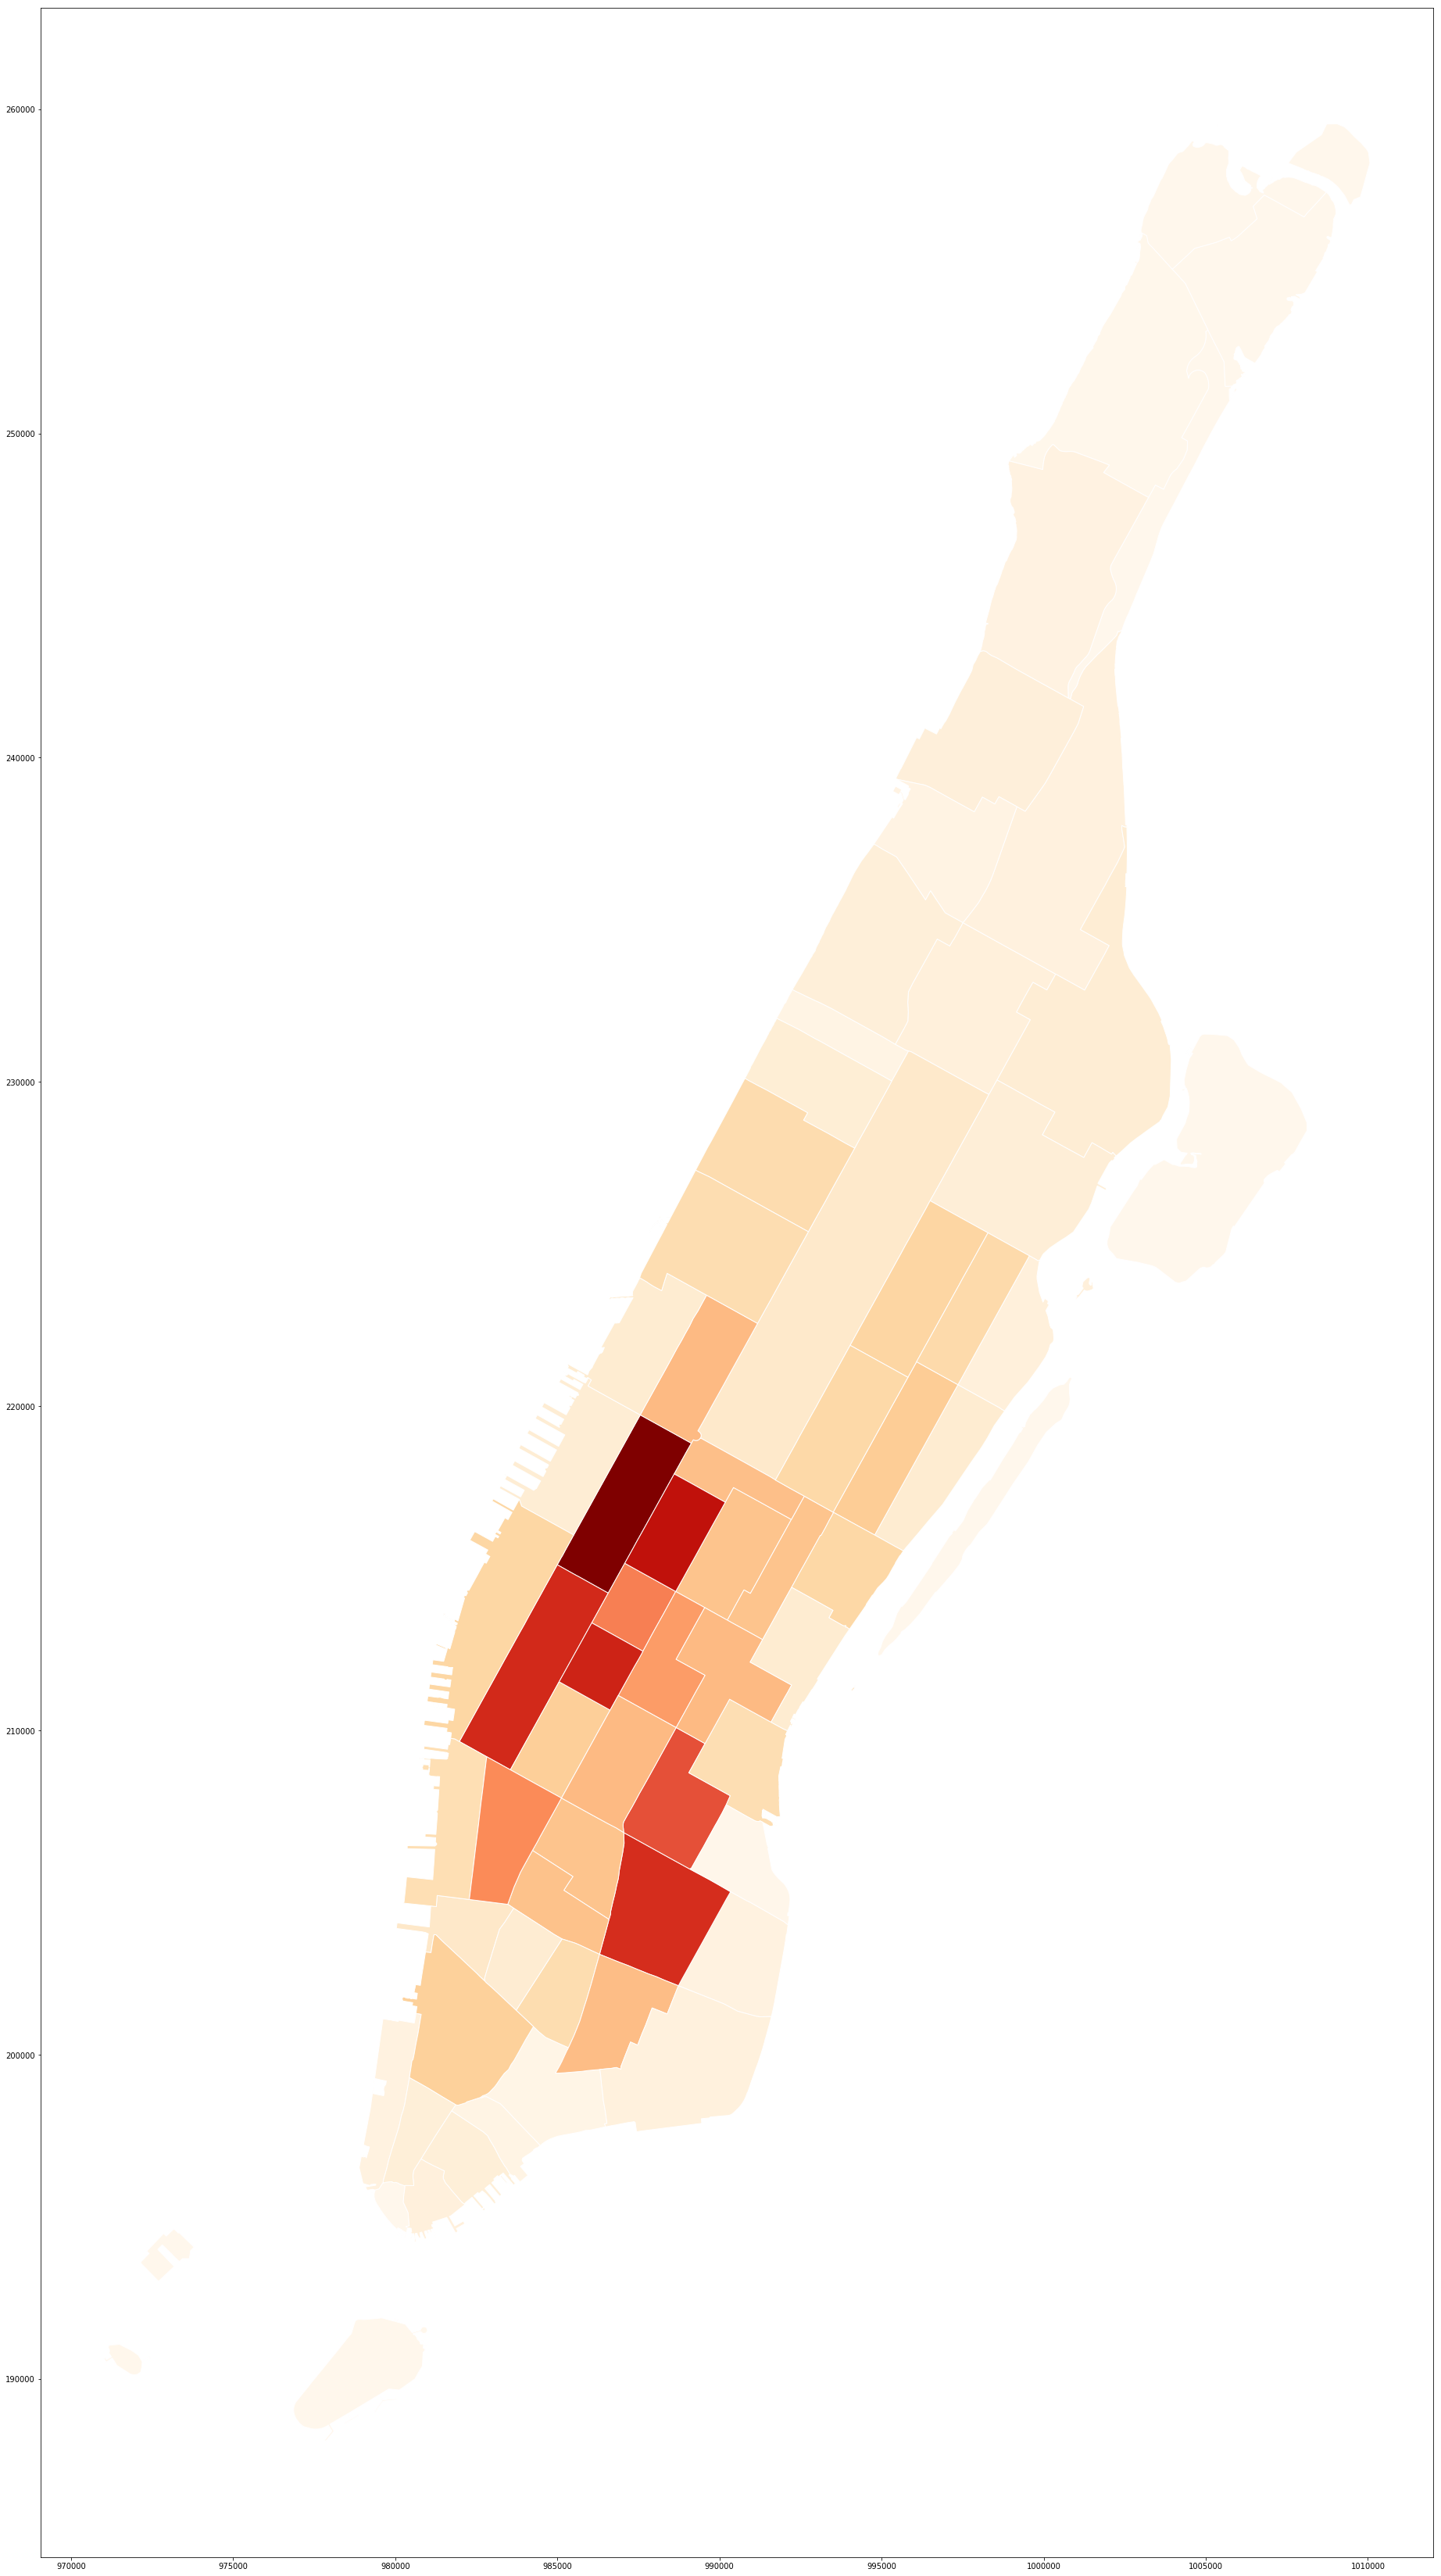

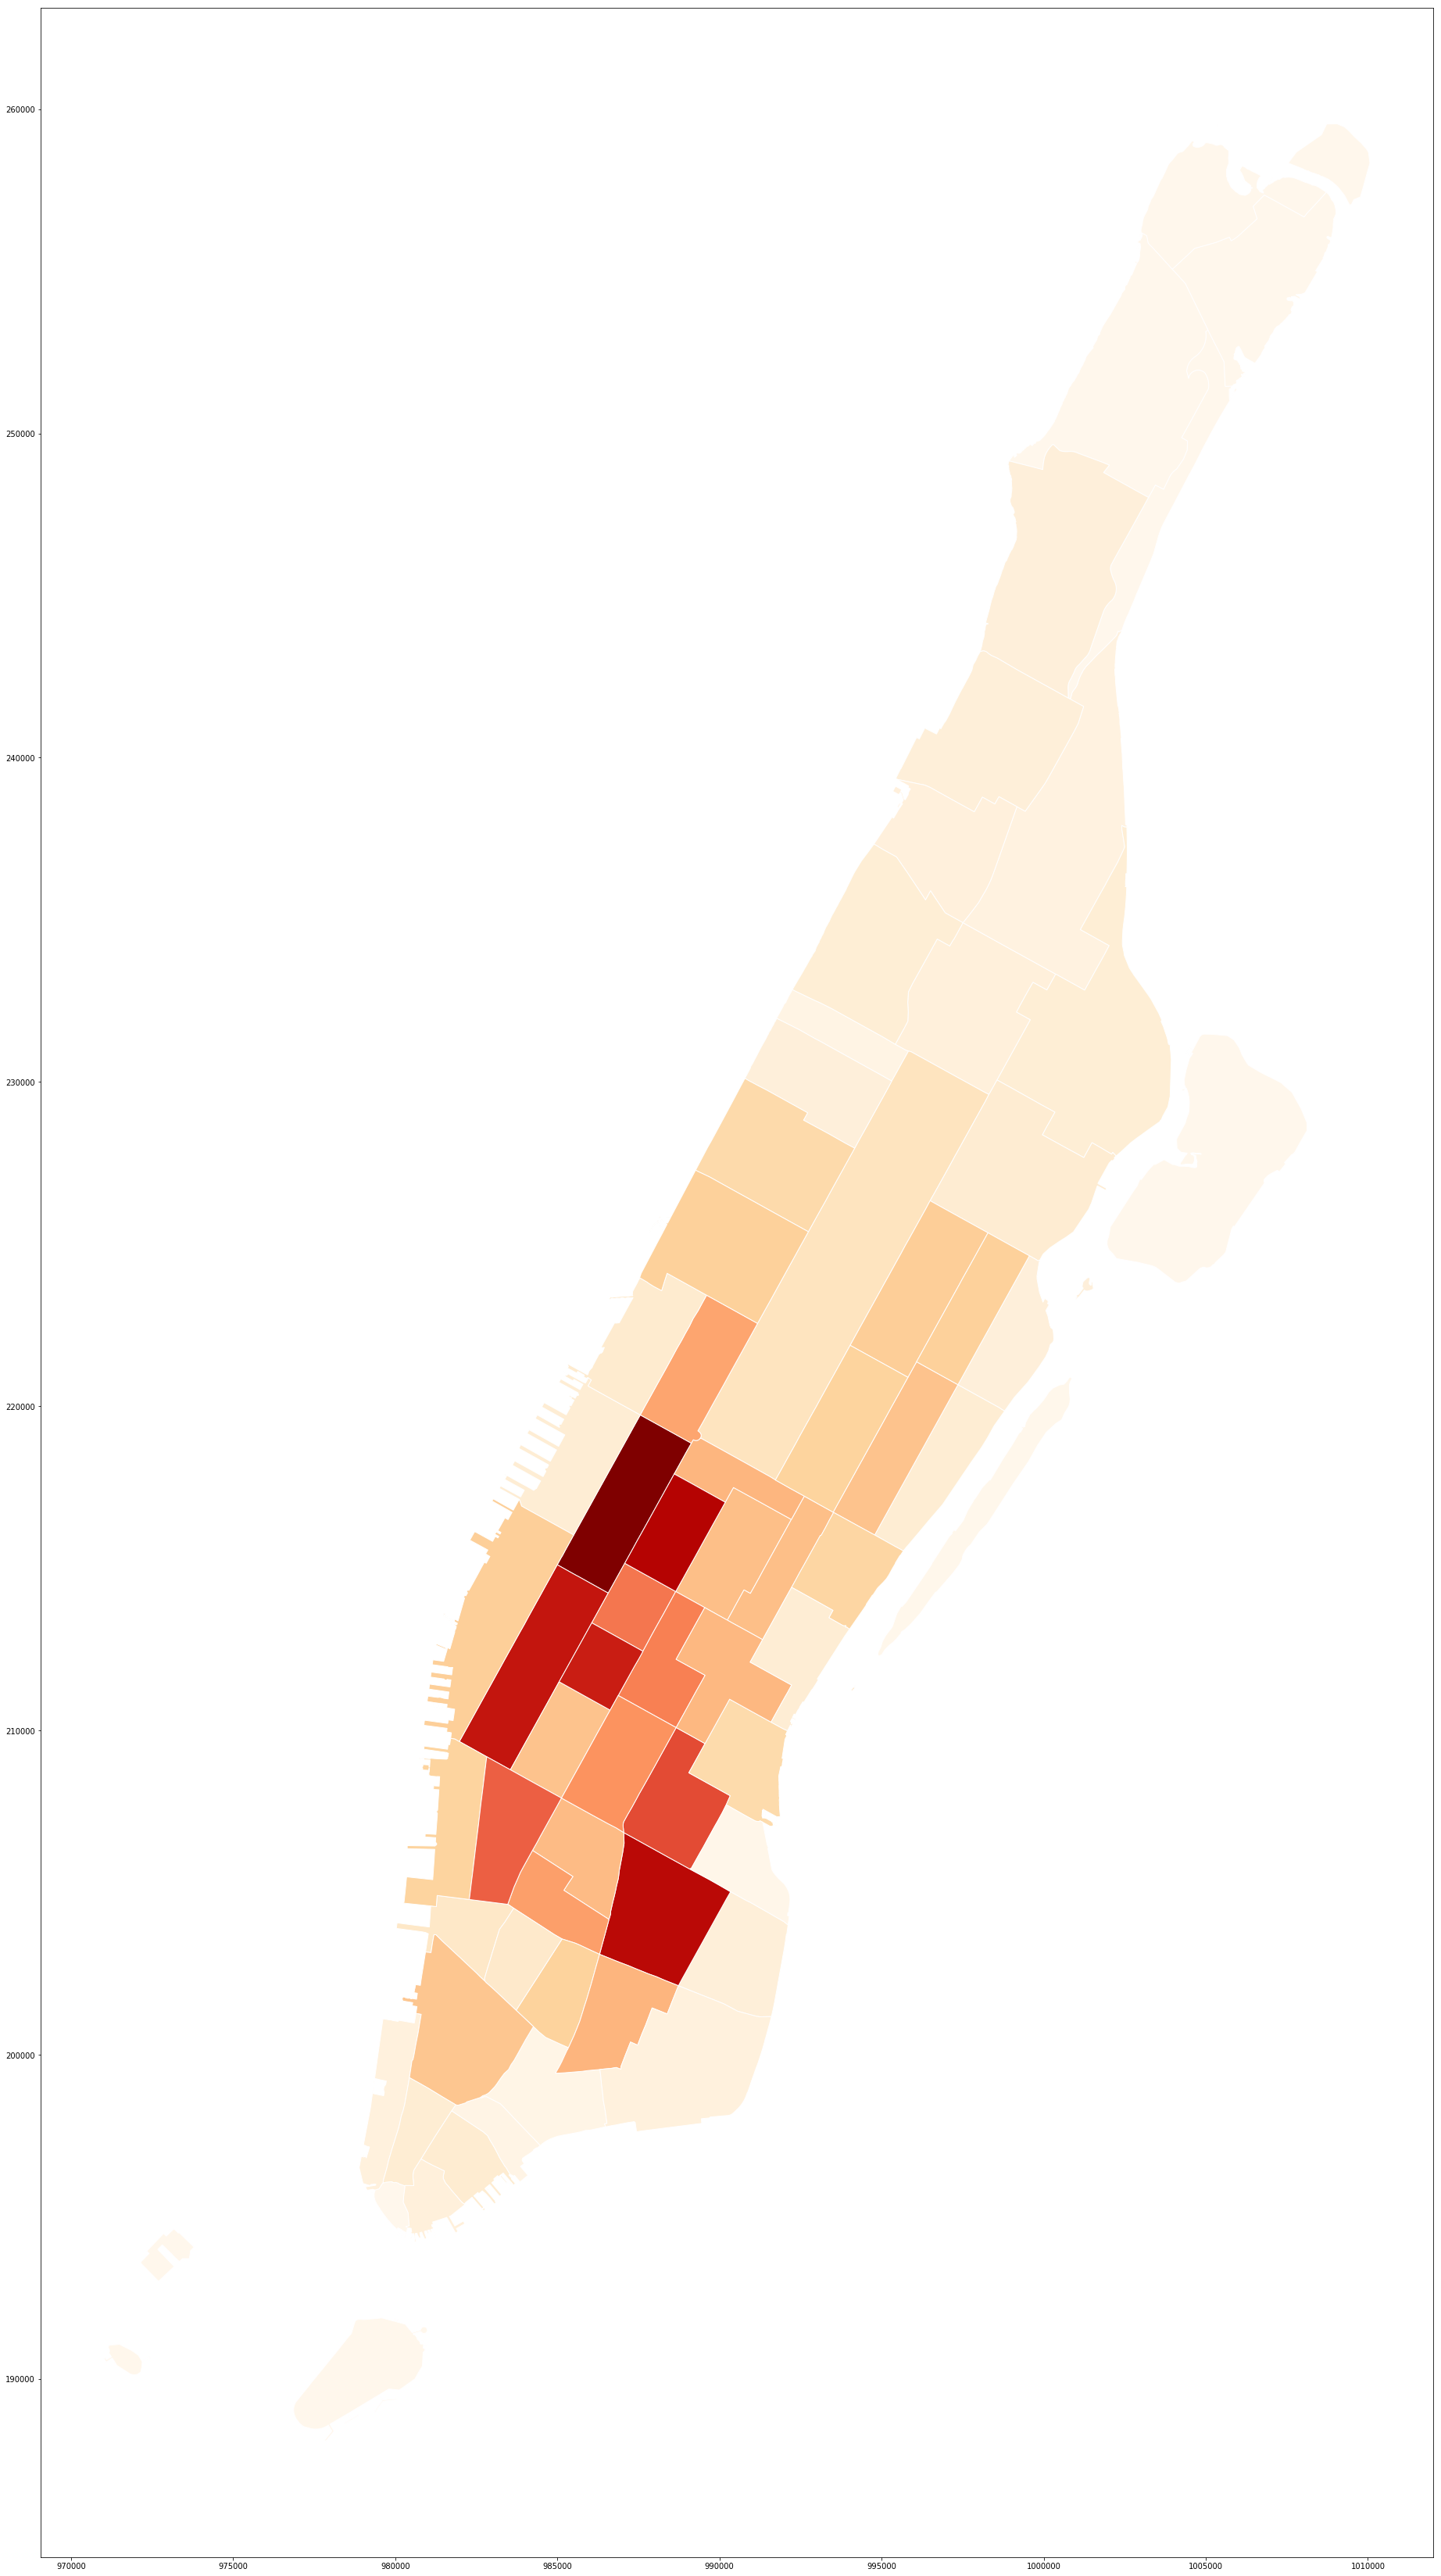

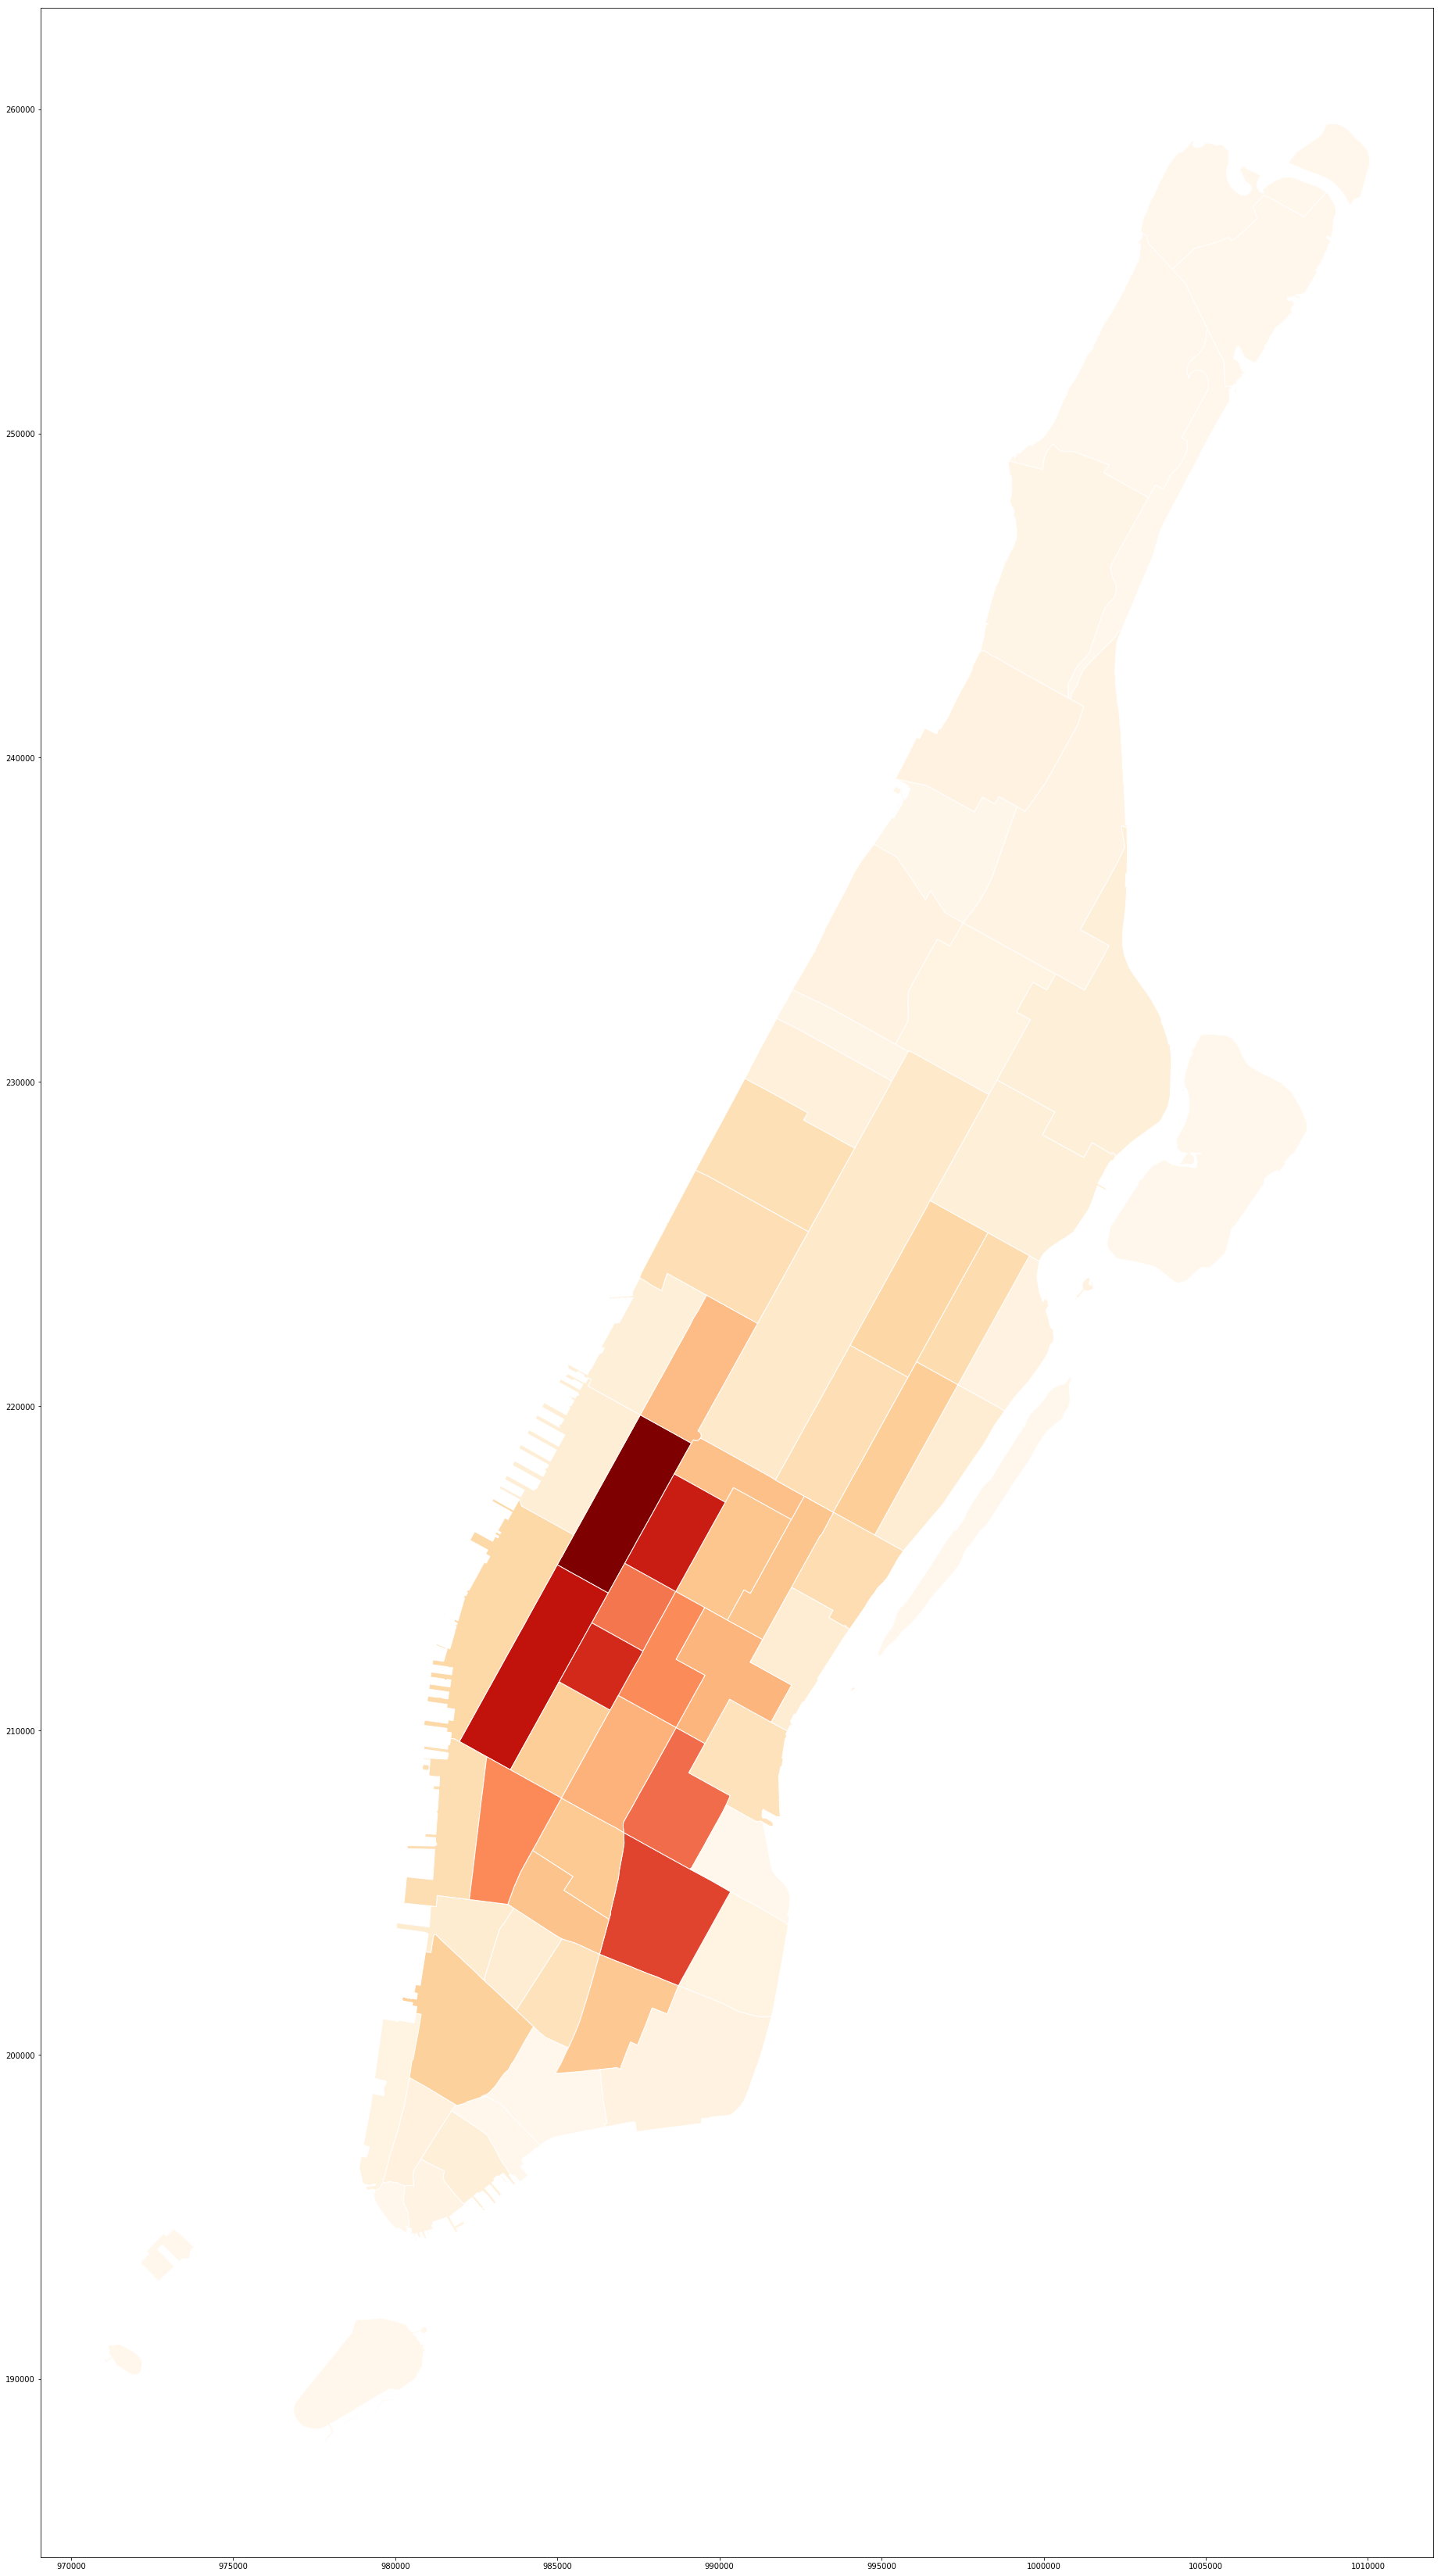

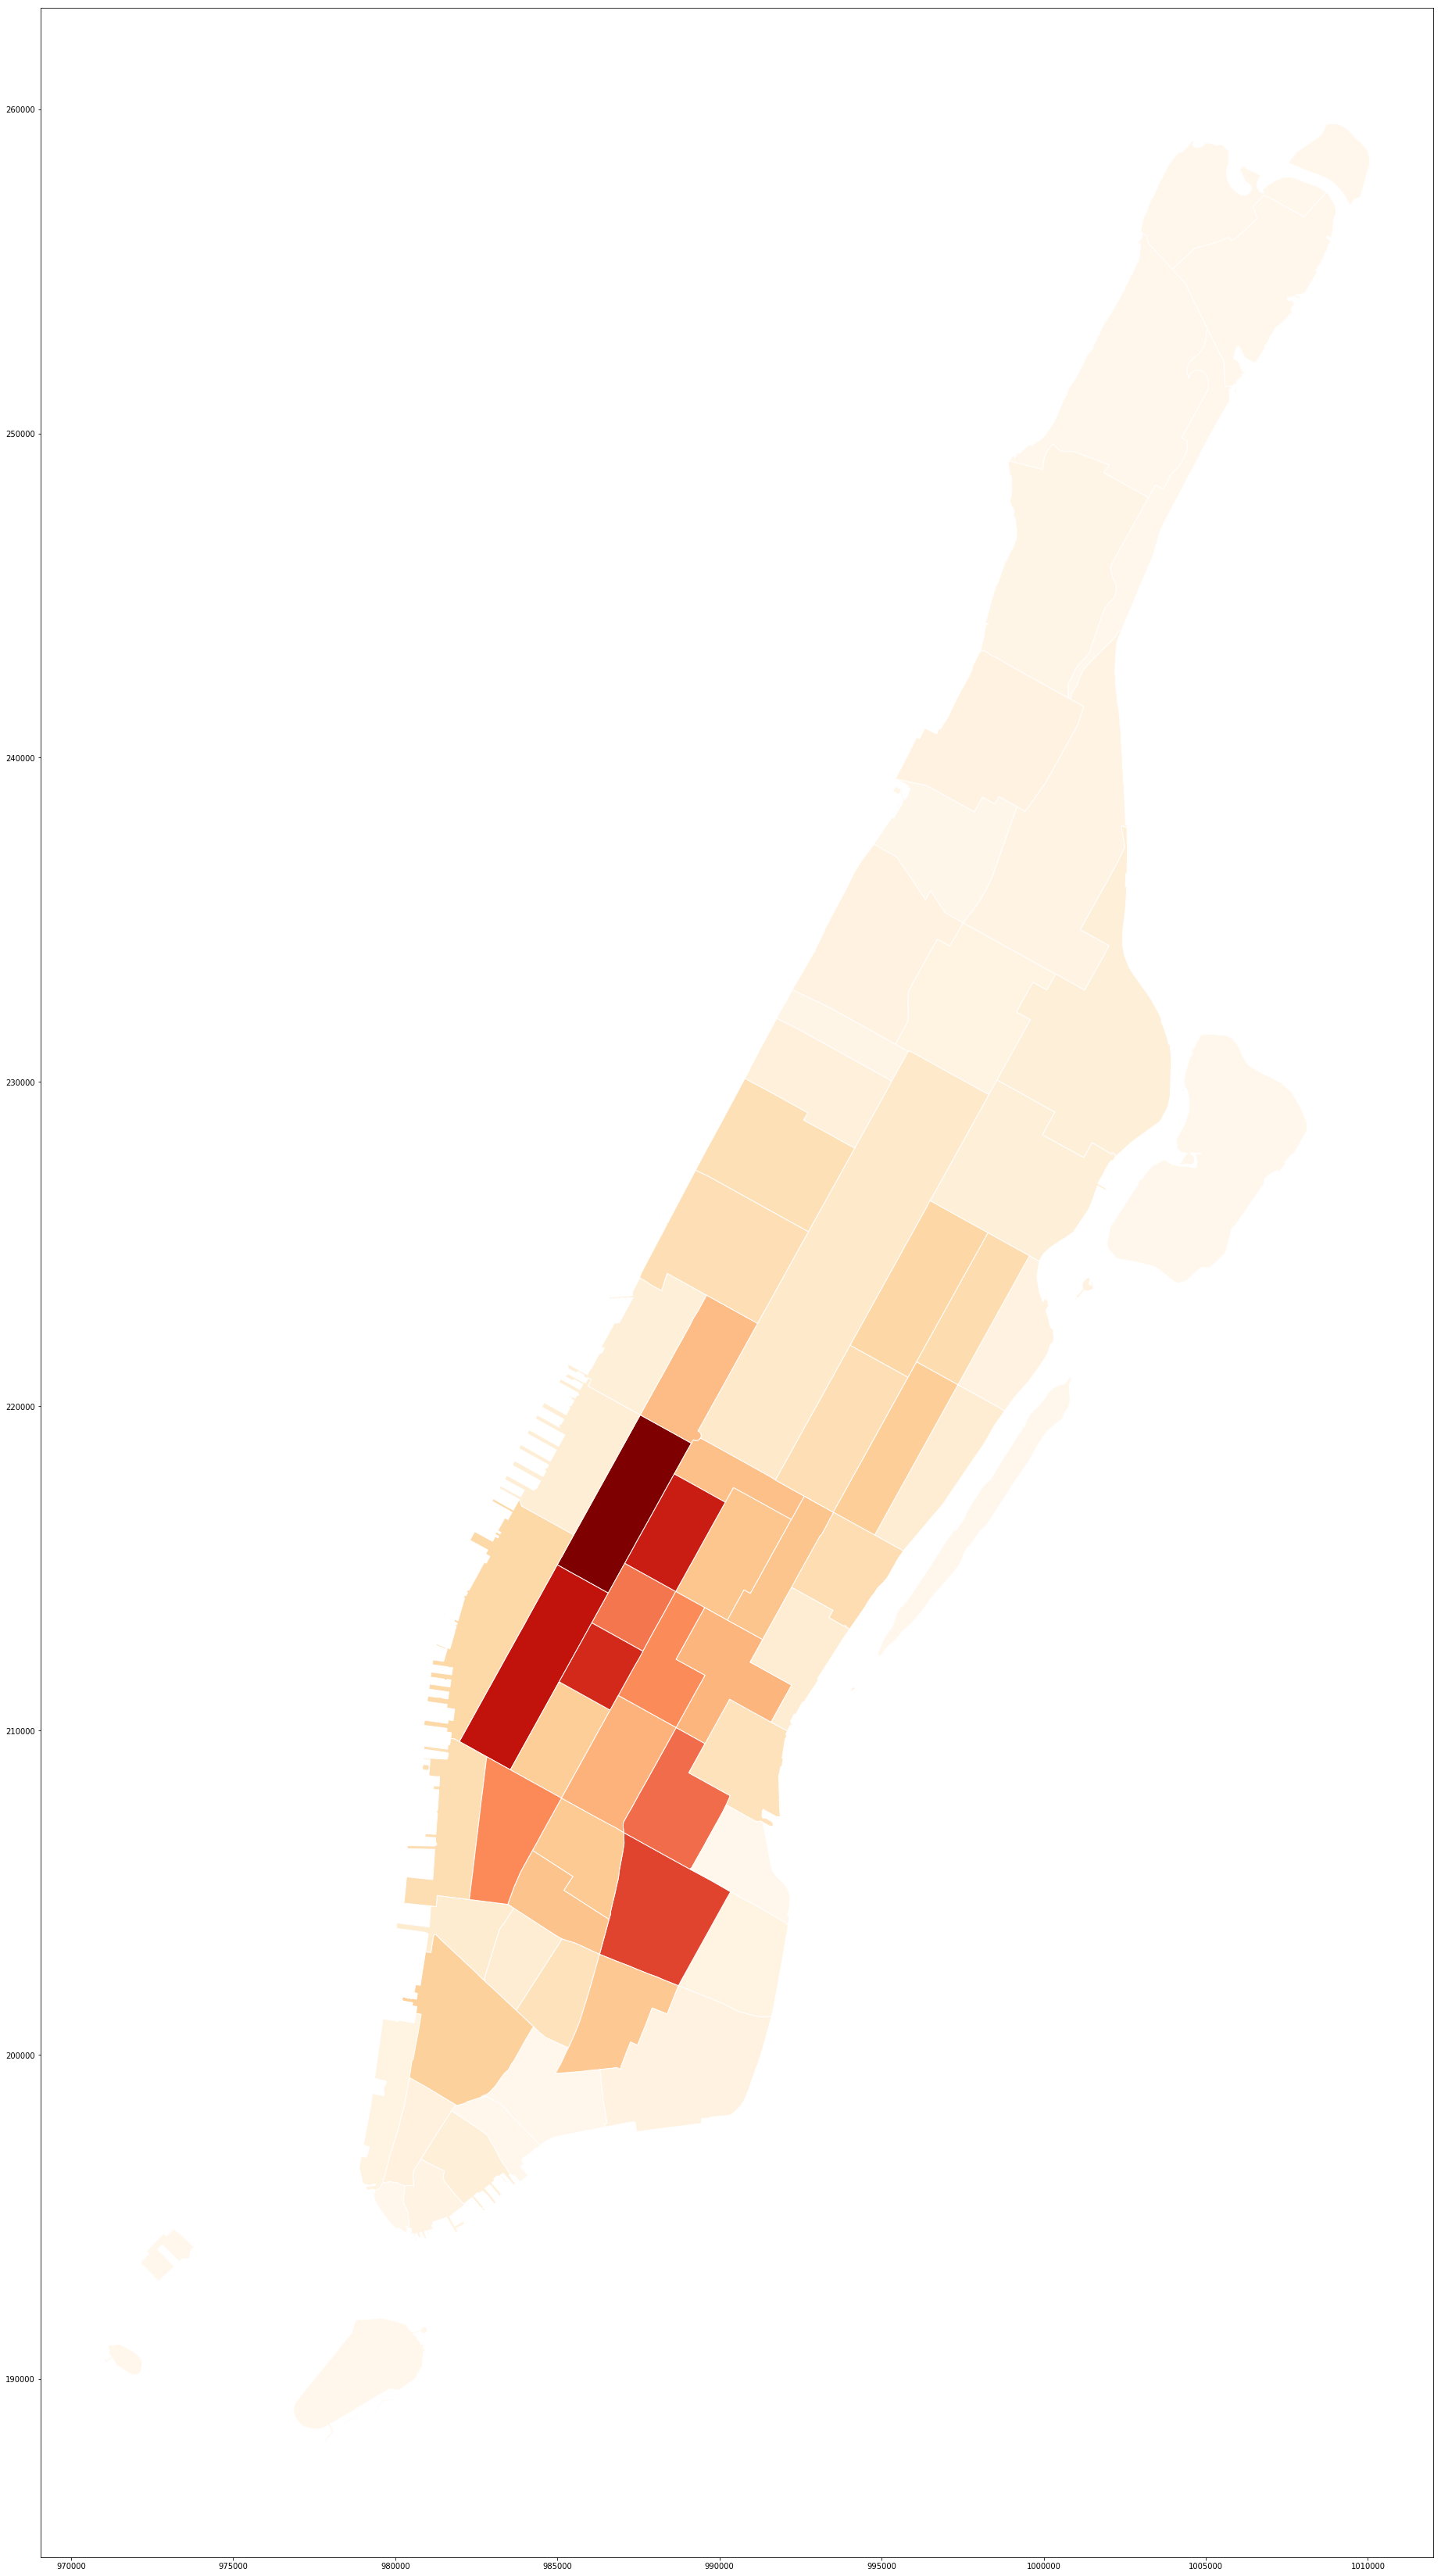

In [110]:
for group_name, group_data in valid_pred_5min.groupby(['tpep_pickup_5min_id']):
    print('group_name:', group_name)
    valid_pred_5min_group = group_data.groupby(['LocationID']).sum()[['value', 'pred_xgb', 'pred_lr', 'pred_tf', 'pred_lgb']]
    taxi_zones_shape_requests_pred_5min = taxi_zones_shape.join(valid_pred_5min_group, on=['LocationID'], how='left')
    taxi_zones_shape_requests_pred_5min.fillna(0, inplace=True)
    taxi_zones_shape_requests_pred_5min.plot(column='value', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_xgb', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lr', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_tf', cmap='OrRd', edgecolor='white')
    taxi_zones_shape_requests_pred_5min.plot(column='pred_lgb', cmap='OrRd', edgecolor='white')

    break

In [111]:
valid_pred_5min_group

,value,pred_xgb,pred_lr,pred_tf,pred_lgb
LocationID,,,,,
4,2.000,1.330,1.537,0.988,0.988
12,1.000,0.043,-0.346,-0.001,-0.001
13,1.000,1.328,1.118,1.003,1.003
24,1.000,0.852,0.381,0.515,0.515
41,1.000,1.694,1.269,1.037,1.037
42,0.000,1.362,0.890,0.849,0.849
43,2.000,3.321,3.992,3.172,3.172
45,0.000,0.630,0.230,-0.001,-0.001
48,23.000,28.642,28.457,27.828,27.828


In [112]:
train_X_5min.to_csv('train_X_5min.csv', index=True)
valid_X_5min.to_csv('valid_X_5min.csv', index=True)
valid_pred_5min.to_csv('valid_pred_5min.csv', index=False)